In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(gprofiler2))
suppressMessages(library(textshape))
suppressMessages(library(ggrepel))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))
suppressMessages(library(scMEGA))
suppressMessages(library(ArchR))

In [3]:
in_dir <- "../../results/07_marchphages/02_annotate"
out_dir <- "../../results/07_marchphages/03_go_analysis"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

In [4]:
df <- read.csv(glue::glue("{in_dir}/top_200_marker_genes.csv"))

In [5]:
head(df)

gene   log.fold.change p.value      adjusted.p.value cluster           
1 ACTB   0.6711102       3.522428e-16 7.686441e-14     Antigen-presenting
2 CD74   0.4944307       1.118637e-13 2.034189e-11     Antigen-presenting
3 RPL26  0.5777528       2.146510e-13 3.857405e-11     Antigen-presenting
4 B2M    0.3158451       1.110753e-10 1.528536e-08     Antigen-presenting
5 RPL27A 0.4473922       2.476232e-09 3.025955e-07     Antigen-presenting
6 RPL31  0.3829825       6.027067e-09 7.249091e-07     Antigen-presenting

In [6]:
df_go <- lapply(unique(df$cluster), function(x){
    df_sub <- subset(df, cluster == x)
    
    gostres <- gost(query = df_sub$gene,
                organism = "hsapiens",
               correction_method = "fdr",
               ordered_query = FALSE,
               significant = FALSE,
               measure_underrepresentation = FALSE)
    
    df_res <- gostres$result
    df_res$cluster <- x
    return(df_res)

}) %>% Reduce(rbind, .) %>%
    subset(., select = c("p_value", "source", "term_name", "cluster"))

In [7]:
write.csv(df_go, glue::glue("{out_dir}/go_analysis.csv"))

In [10]:
head(df_go)

p_value      source
1 3.538863e-63 CORUM 
2 1.847290e-38 CORUM 
3 7.451381e-36 CORUM 
4 3.266624e-25 CORUM 
5 2.574389e-24 CORUM 
6 7.779150e-16 CORUM 
  term_name                                                                                     
1 Ribosome, cytoplasmic                                                                         
2 Nop56p-associated pre-rRNA complex                                                            
3 60S ribosomal subunit, cytoplasmic                                                            
4 40S ribosomal subunit, cytoplasmic                                                            
5 40S ribosomal subunit, cytoplasmic                                                            
6 TRBP containing complex (DICER, RPL7A, EIF6, MOV10 and subunits of the 60S ribosomal particle)
  cluster           
1 Antigen-presenting
2 Antigen-presenting
3 Antigen-presenting
4 Antigen-presenting
5 Antigen-presenting
6 Antigen-presenting

In [11]:
df2 <- subset(df_go, source == "GO:BP")

In [13]:
nrow(df2)

[1] 12849

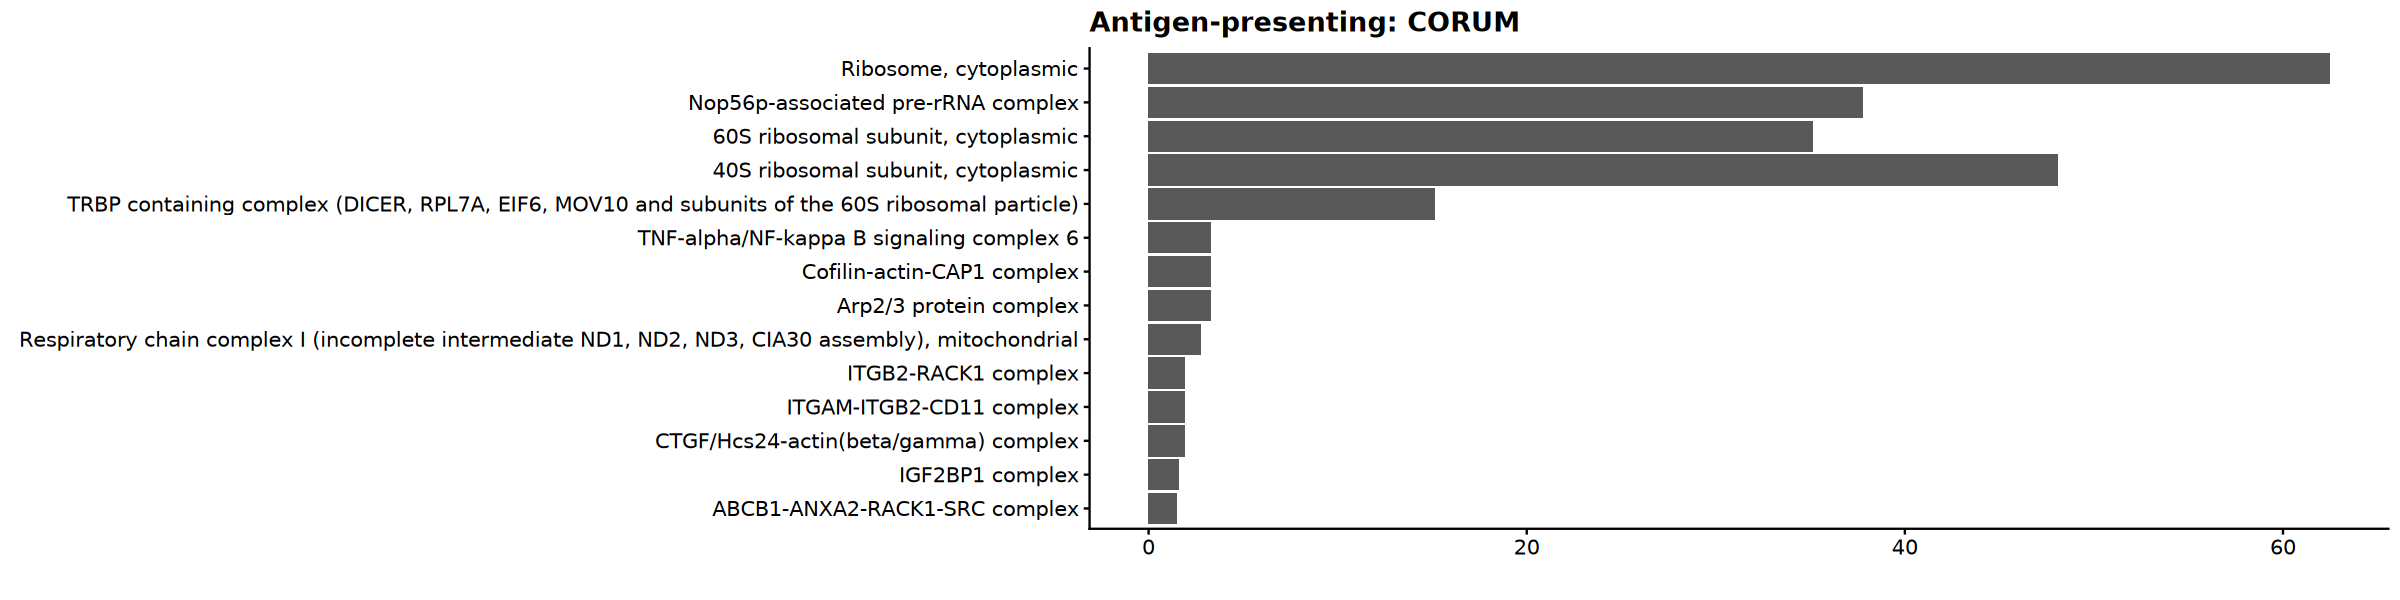

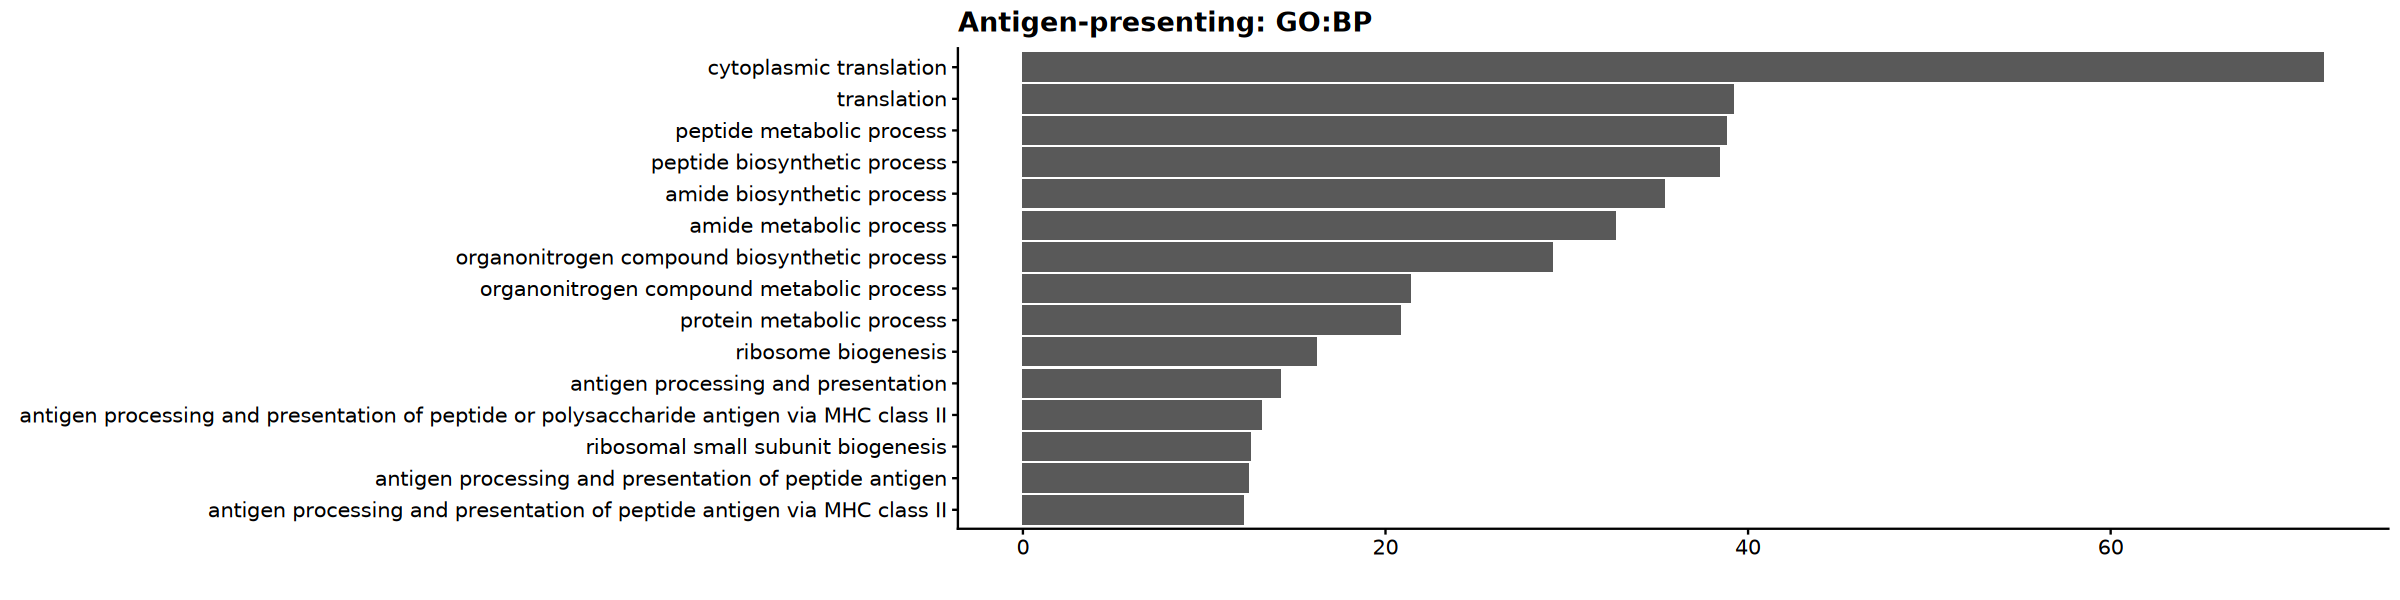

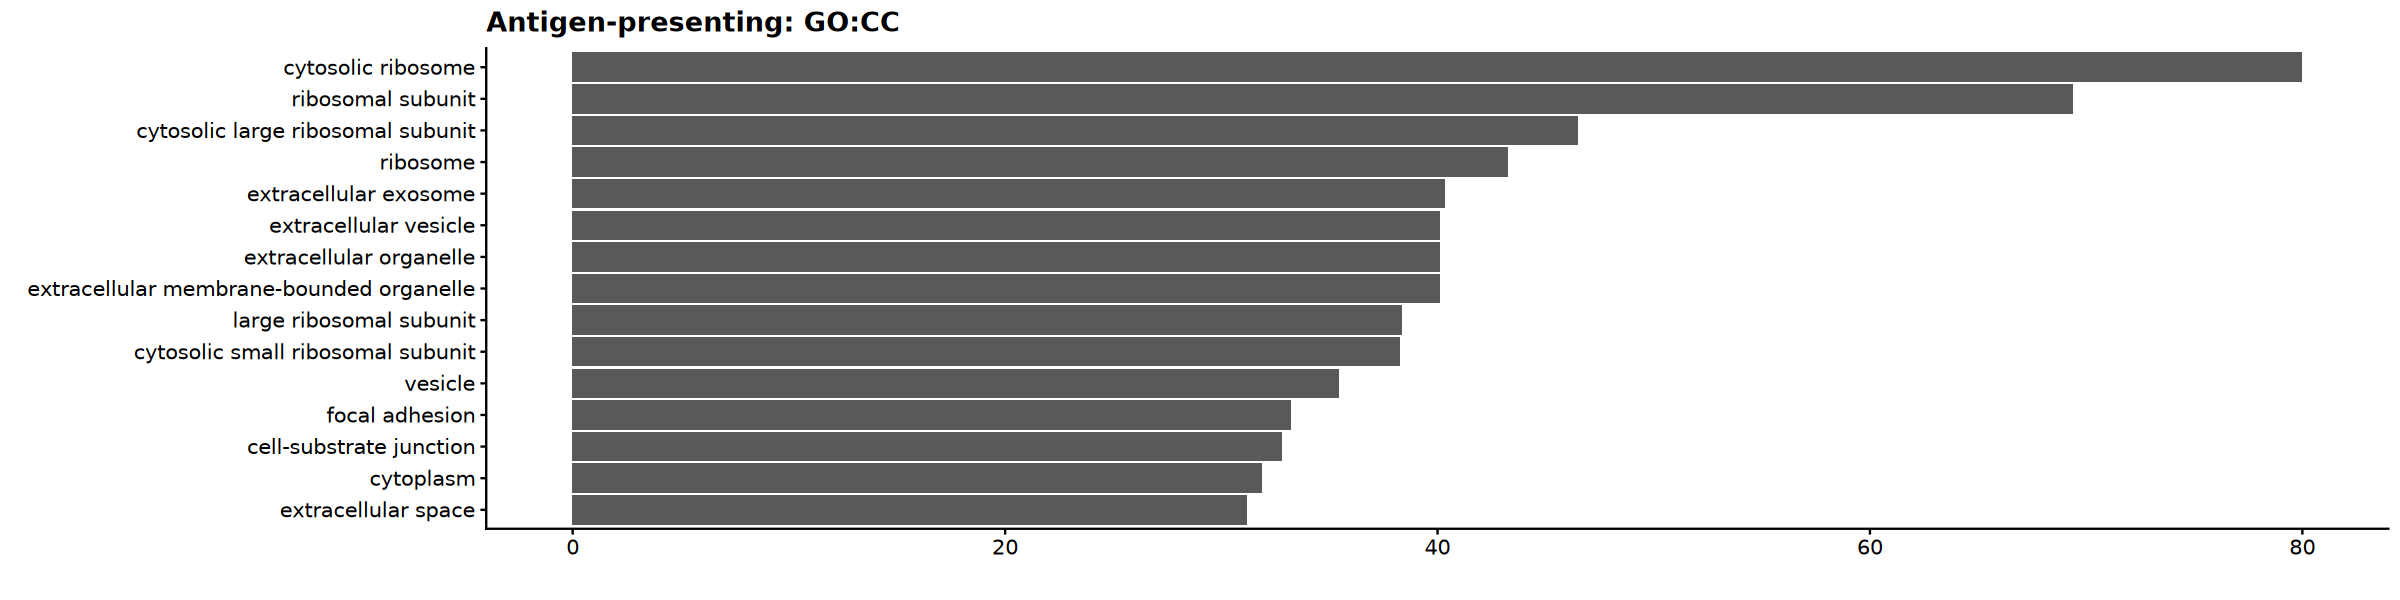

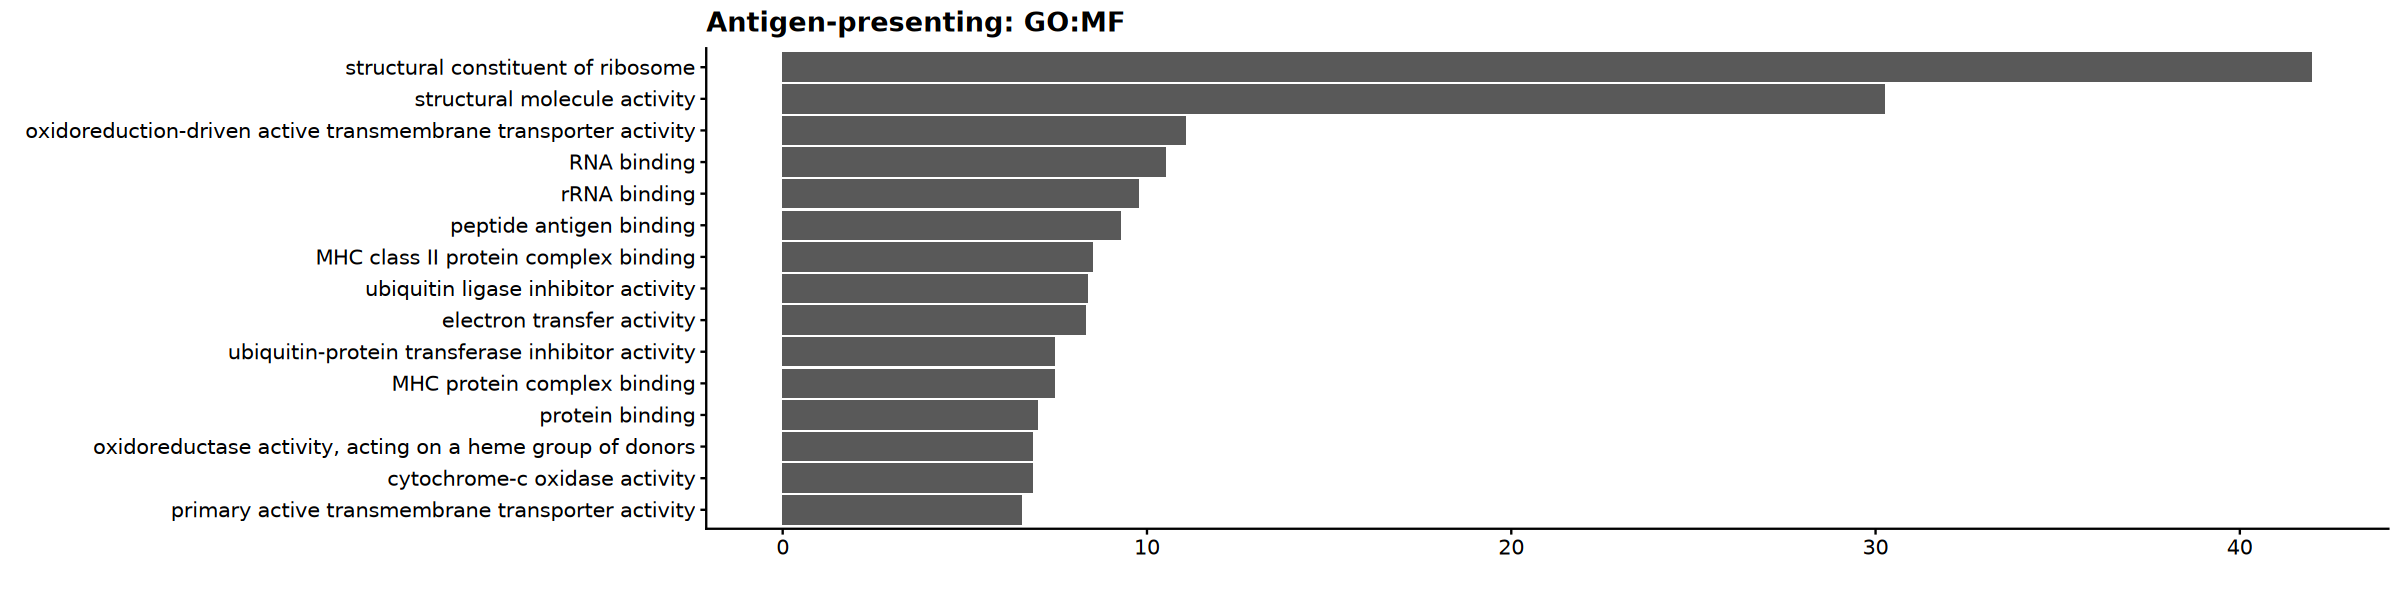

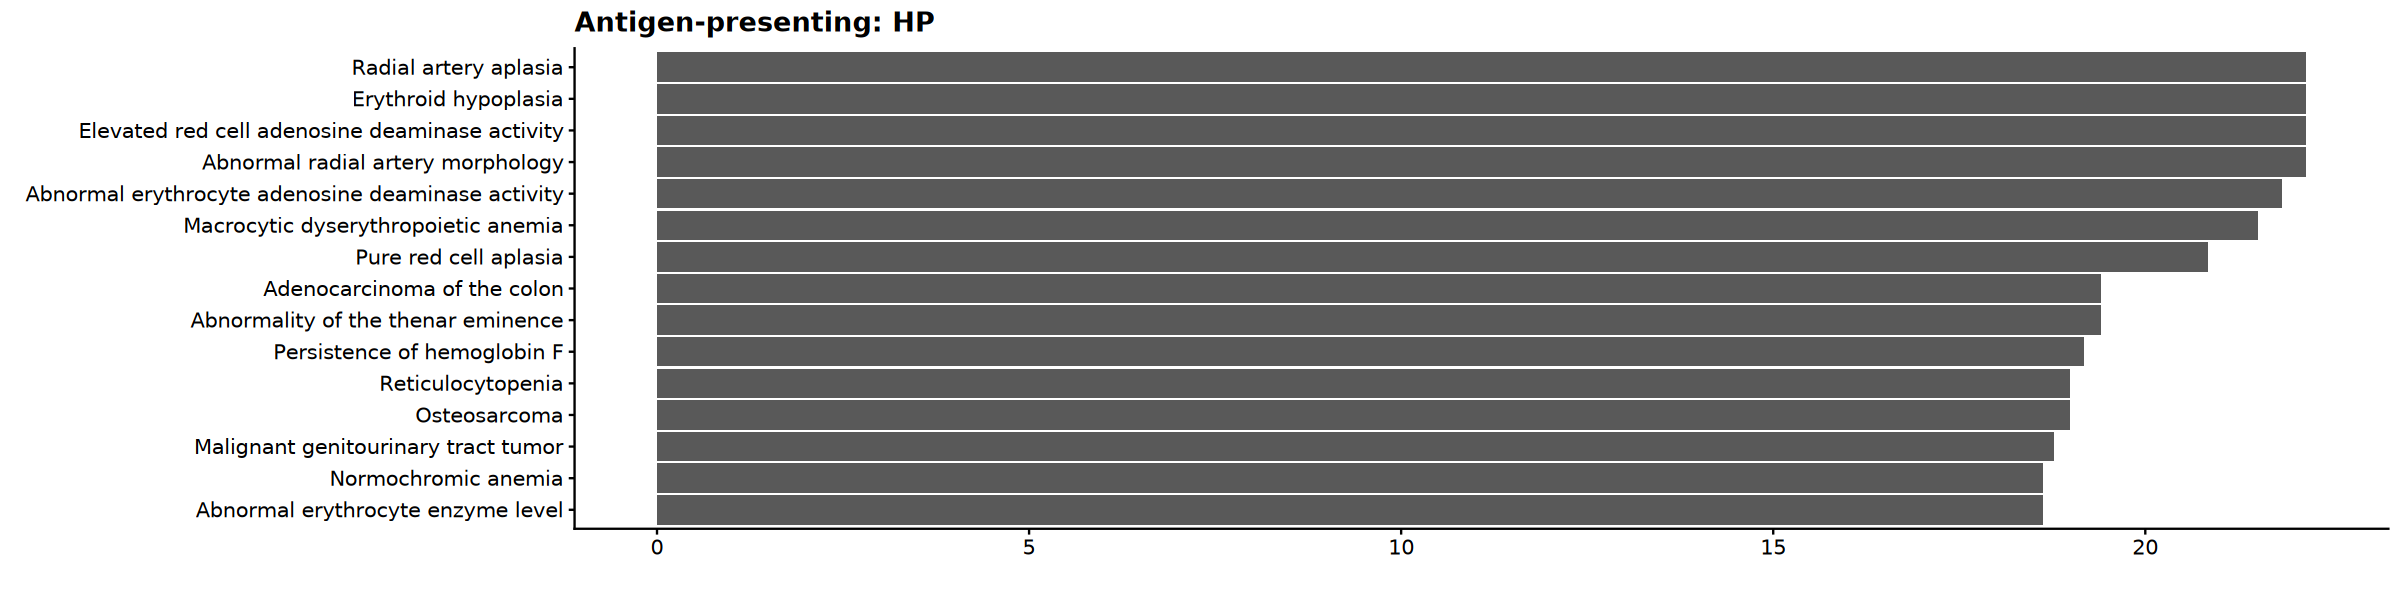

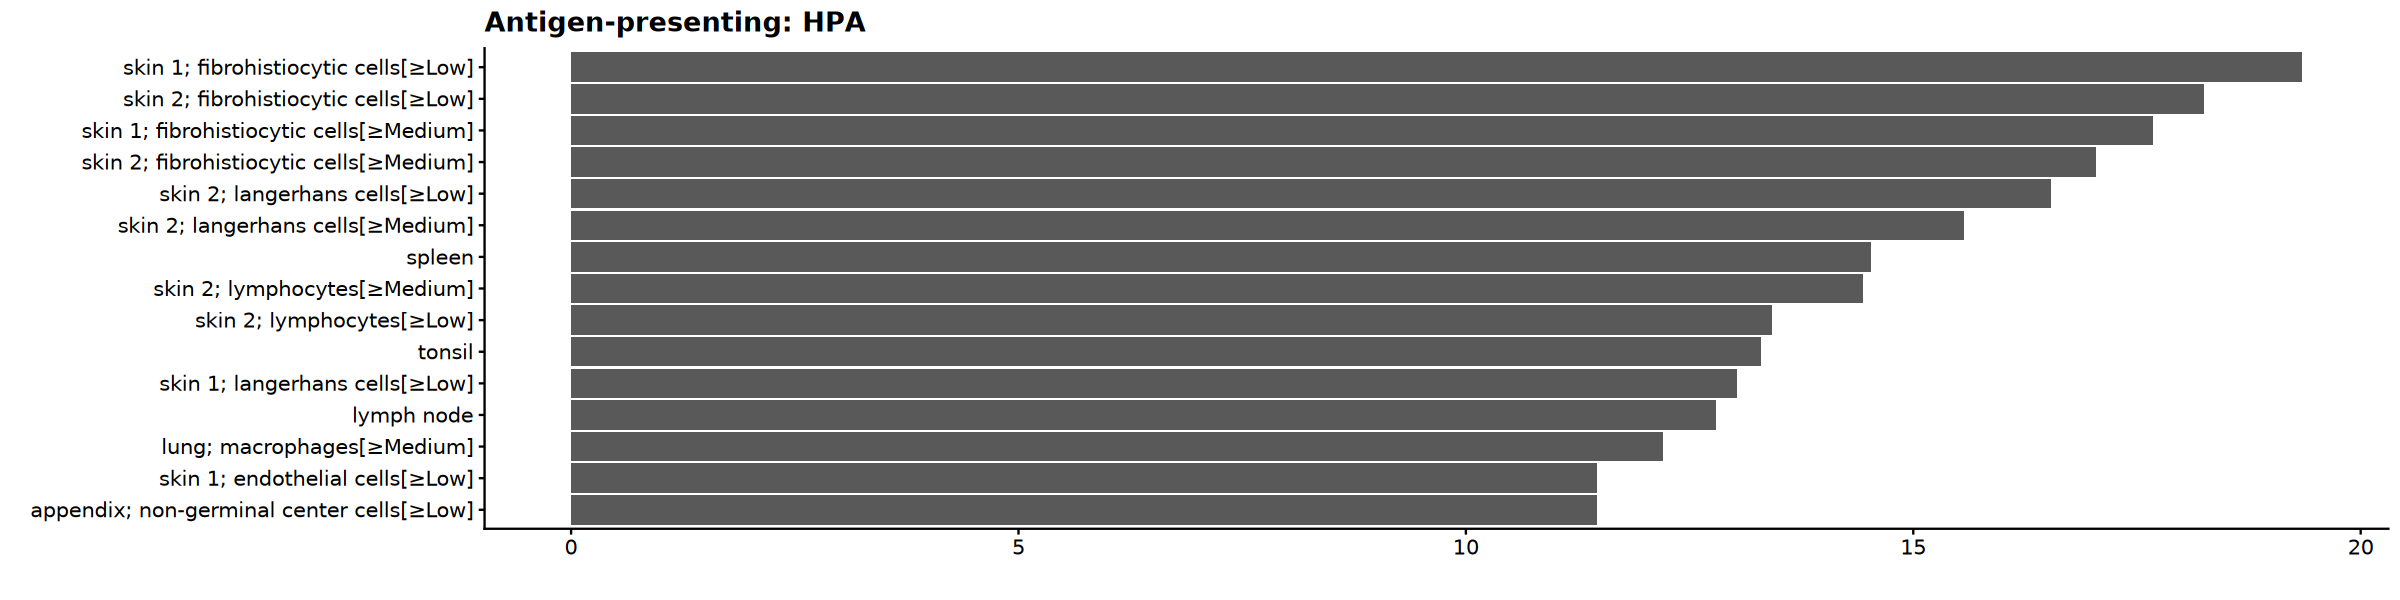

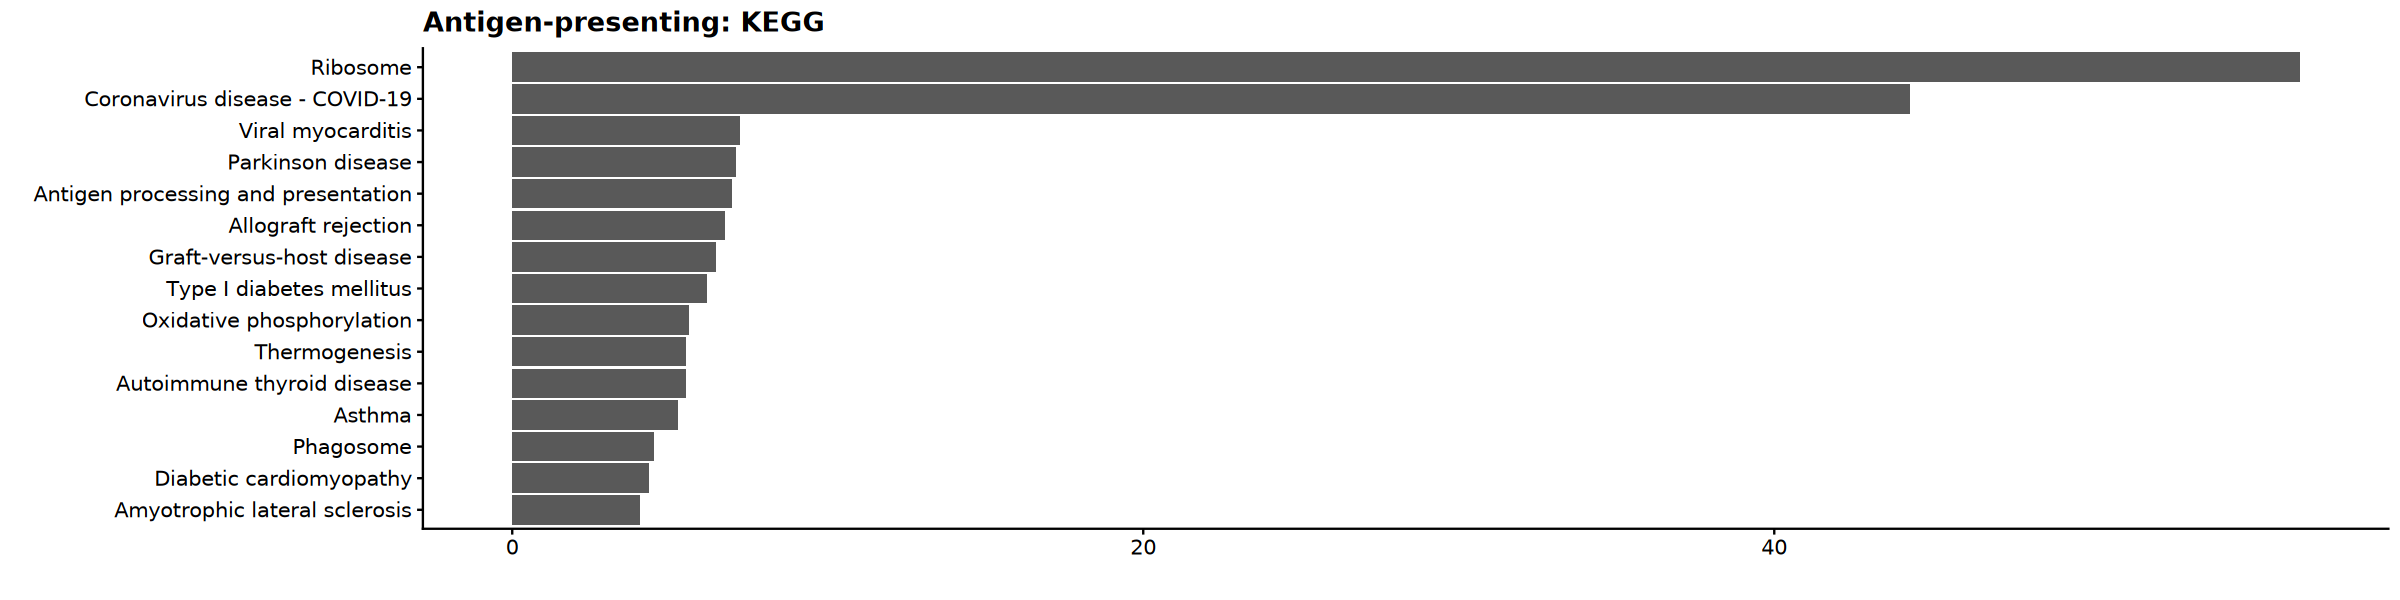

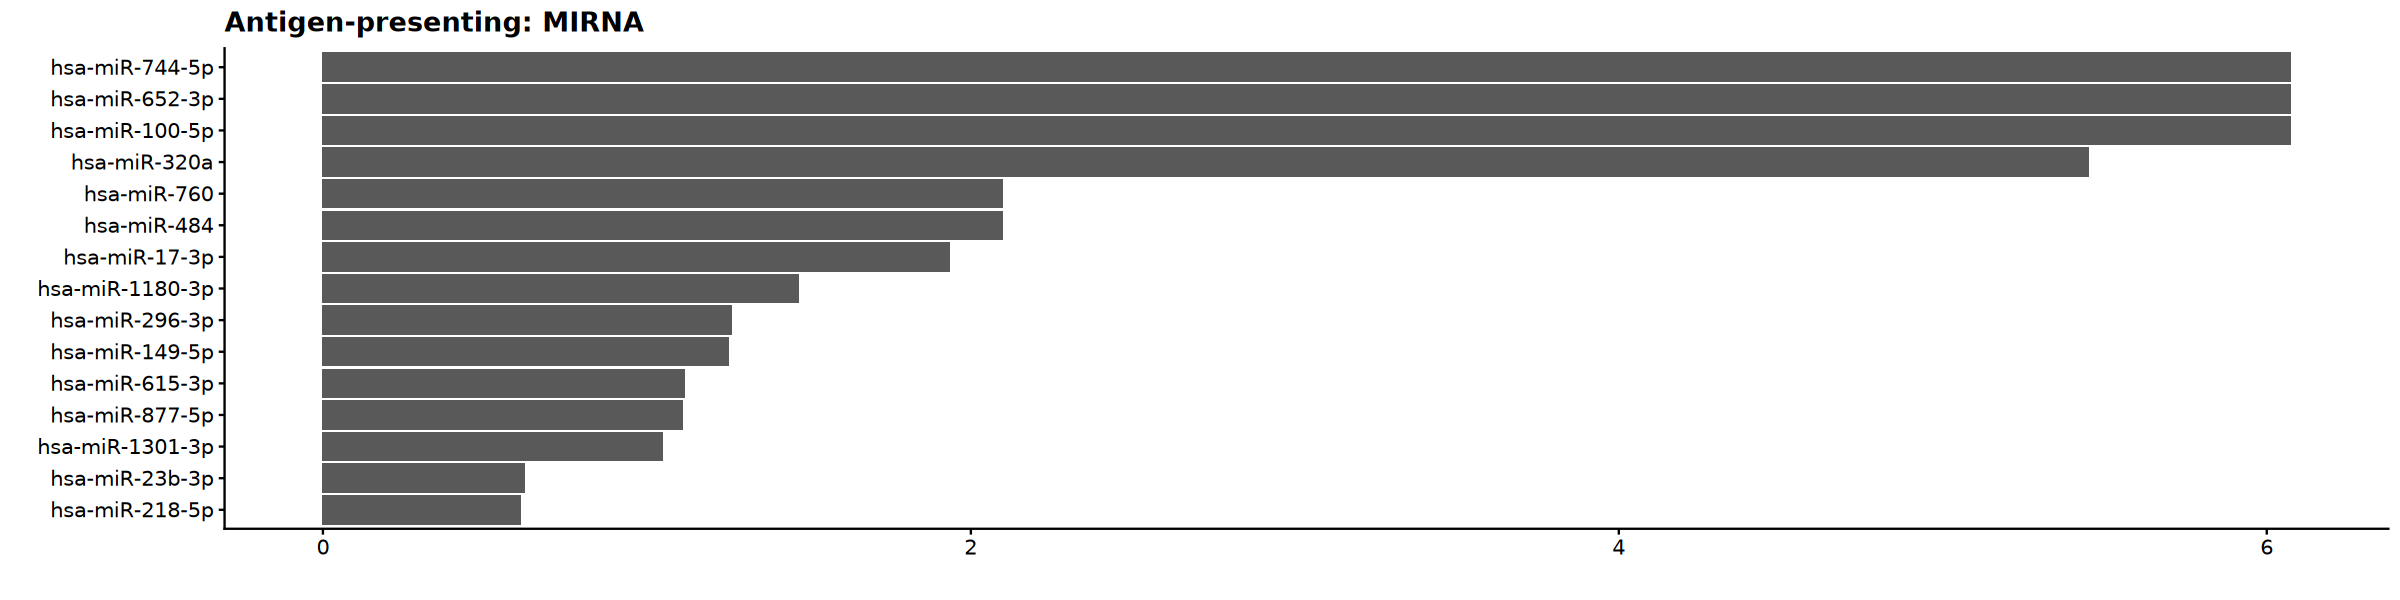

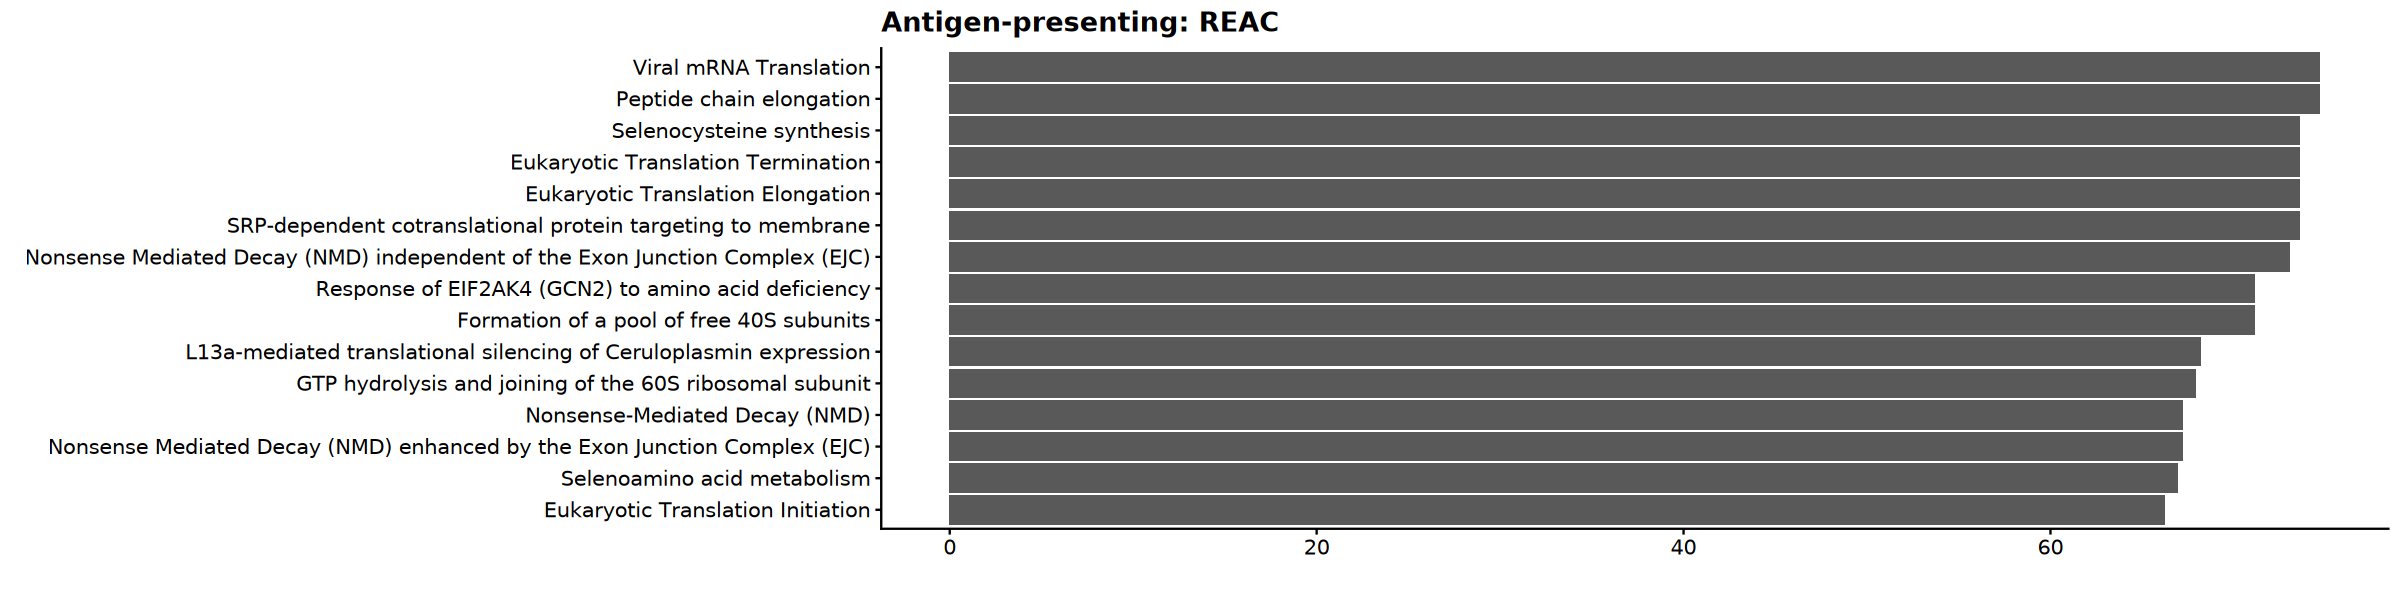

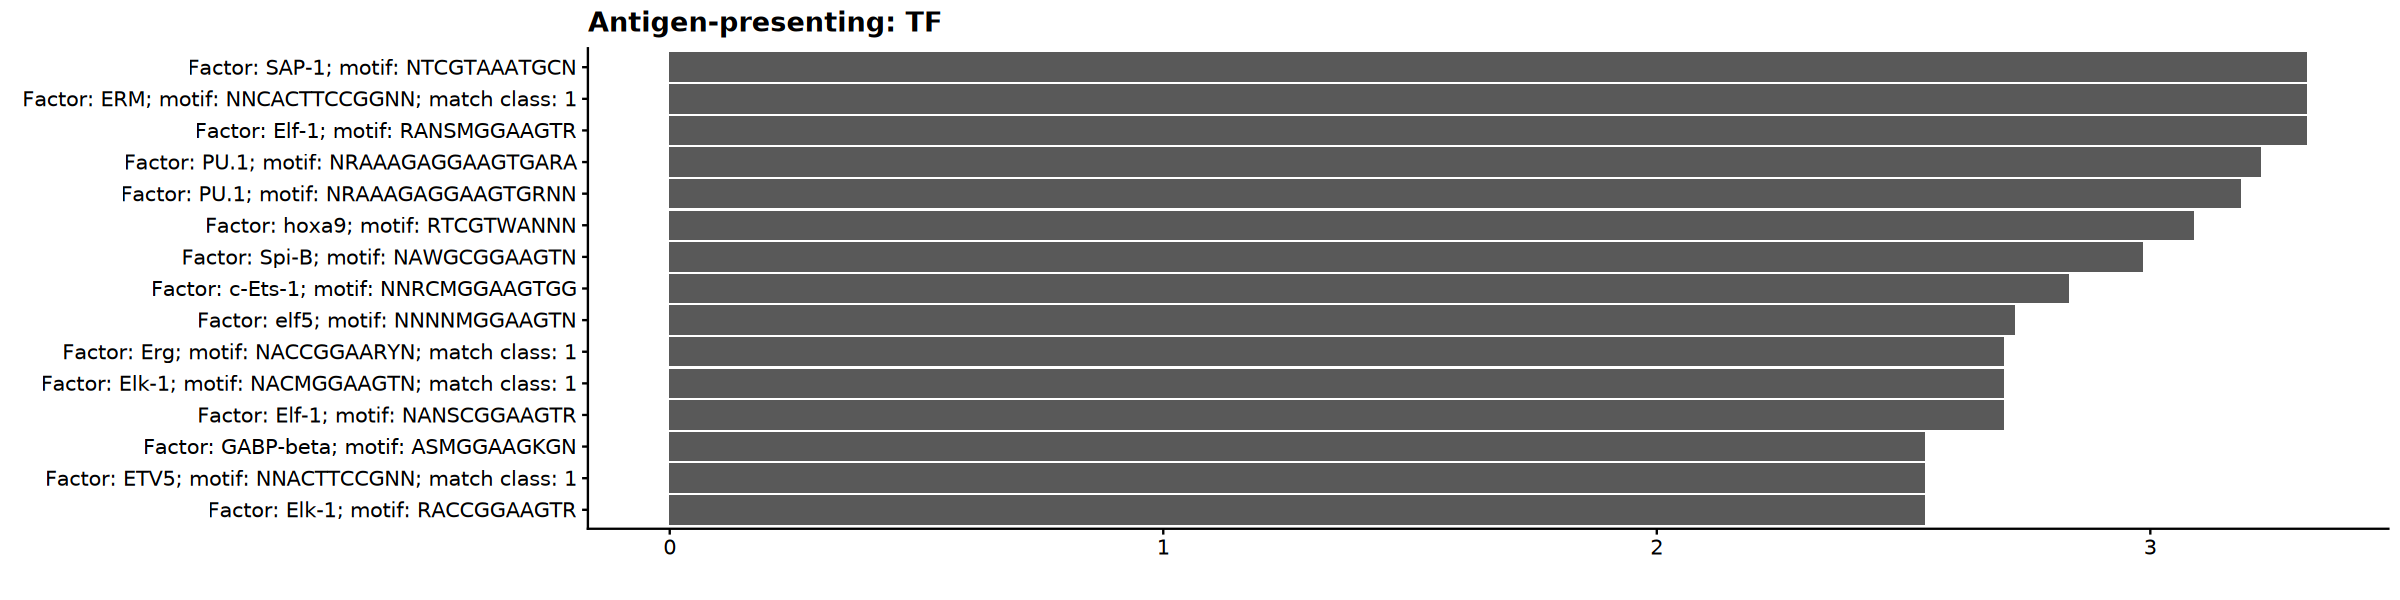

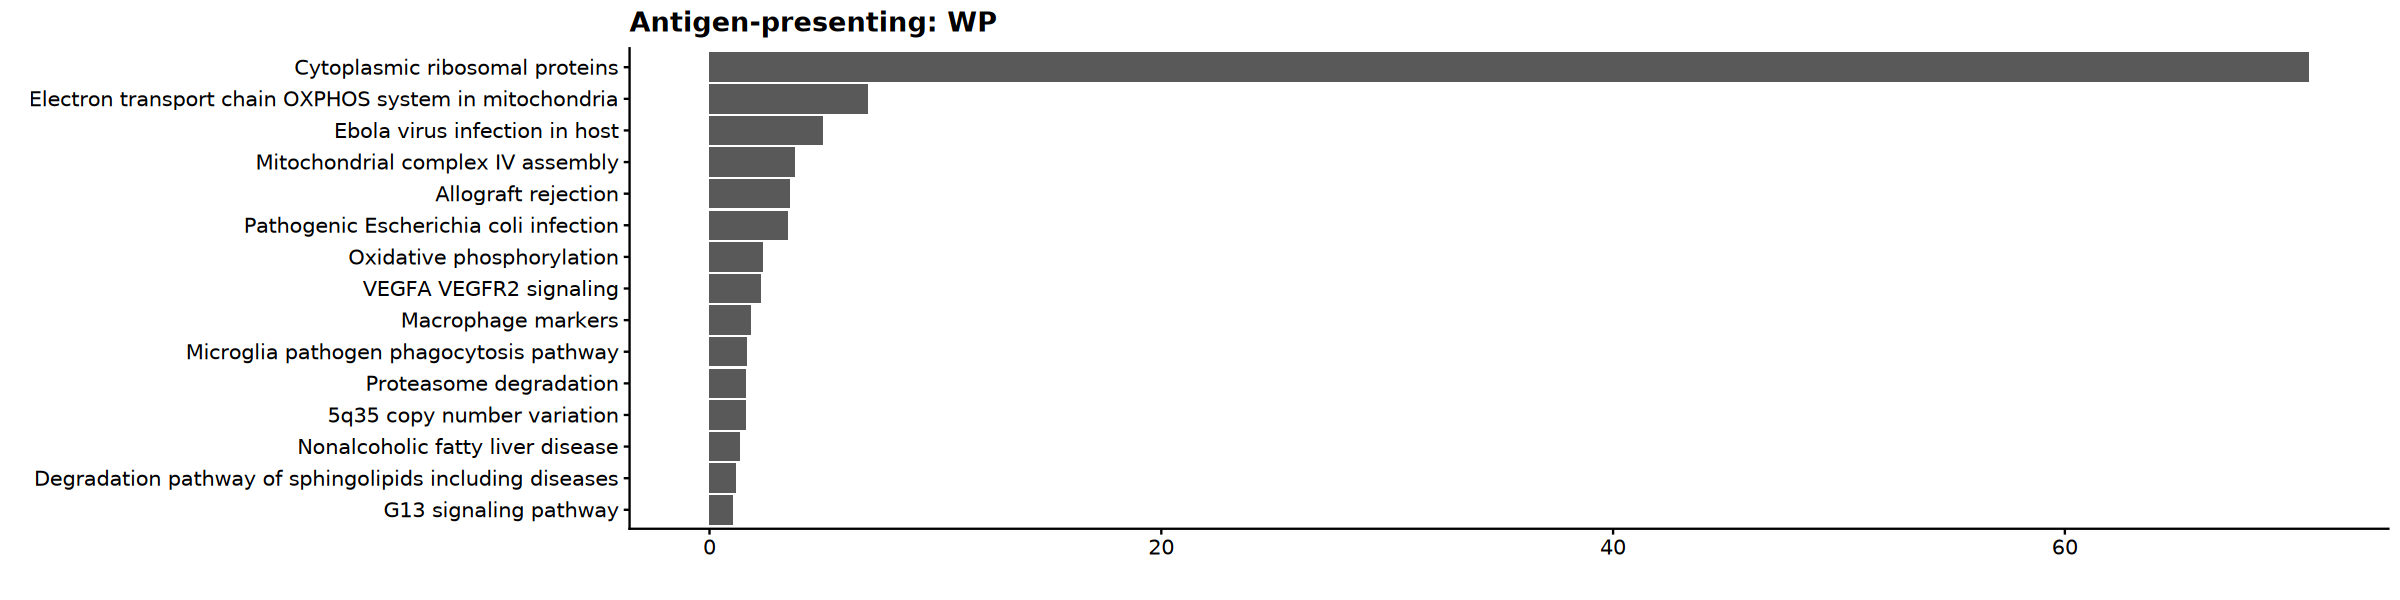

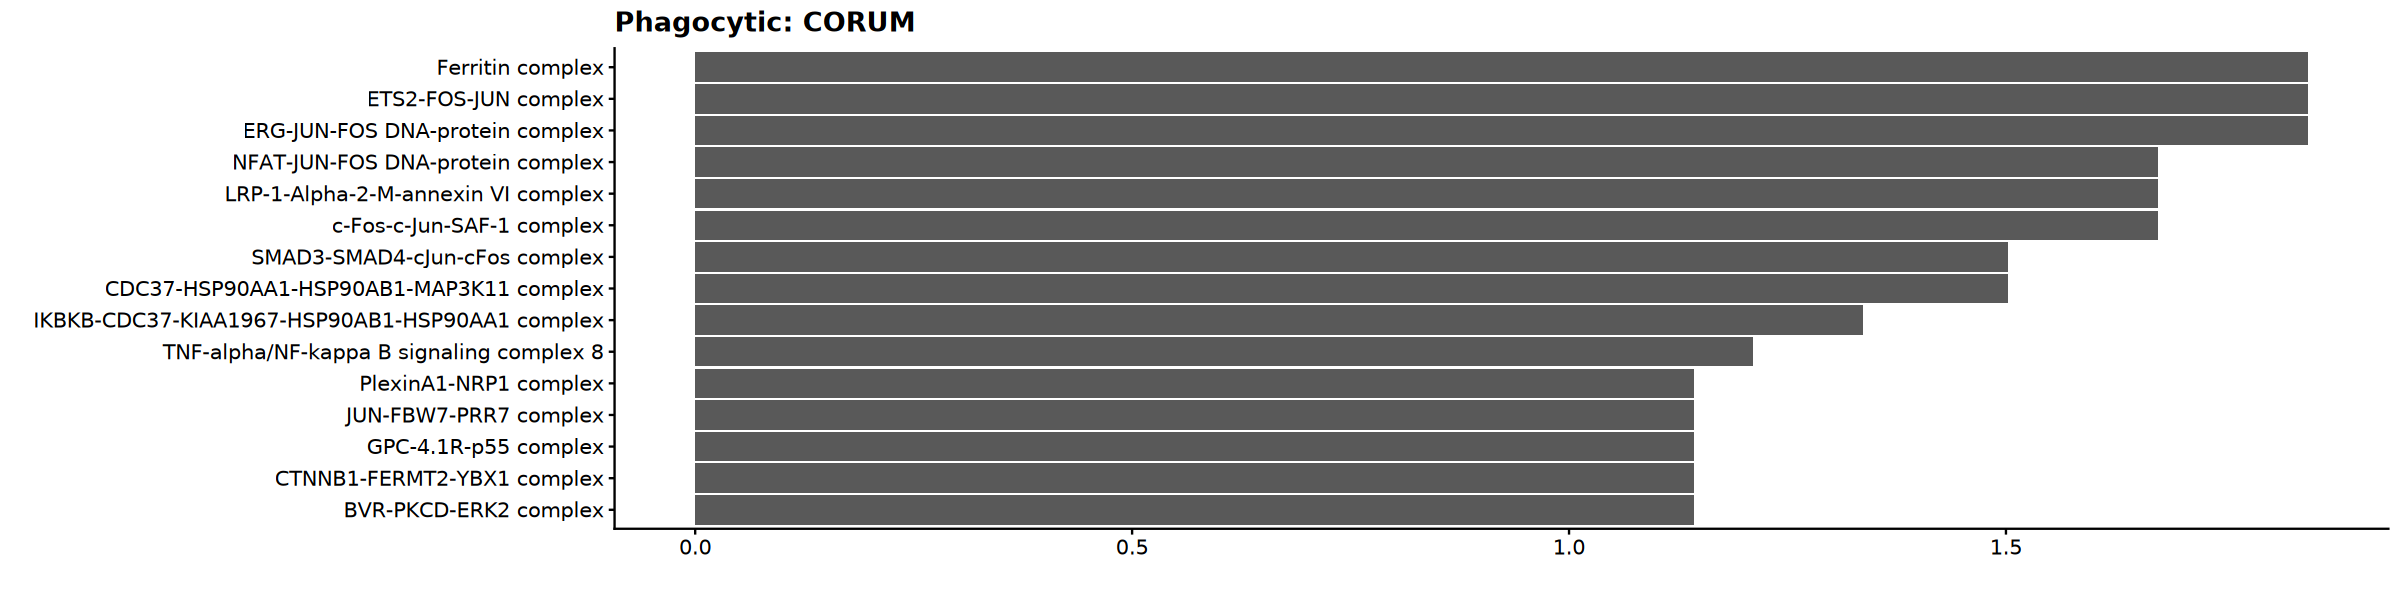

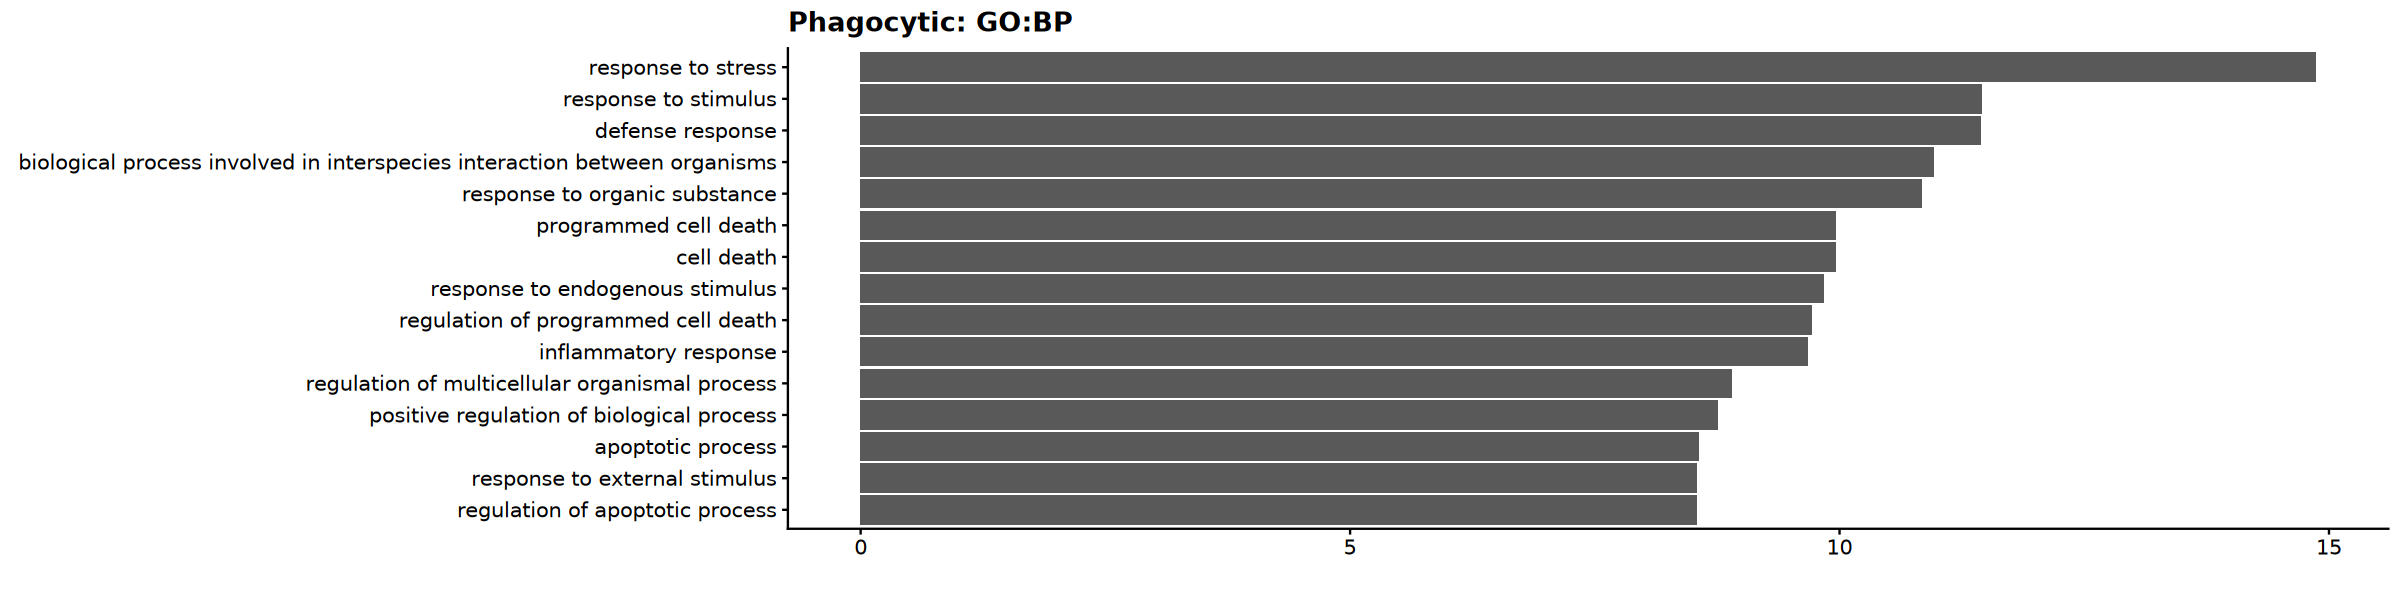

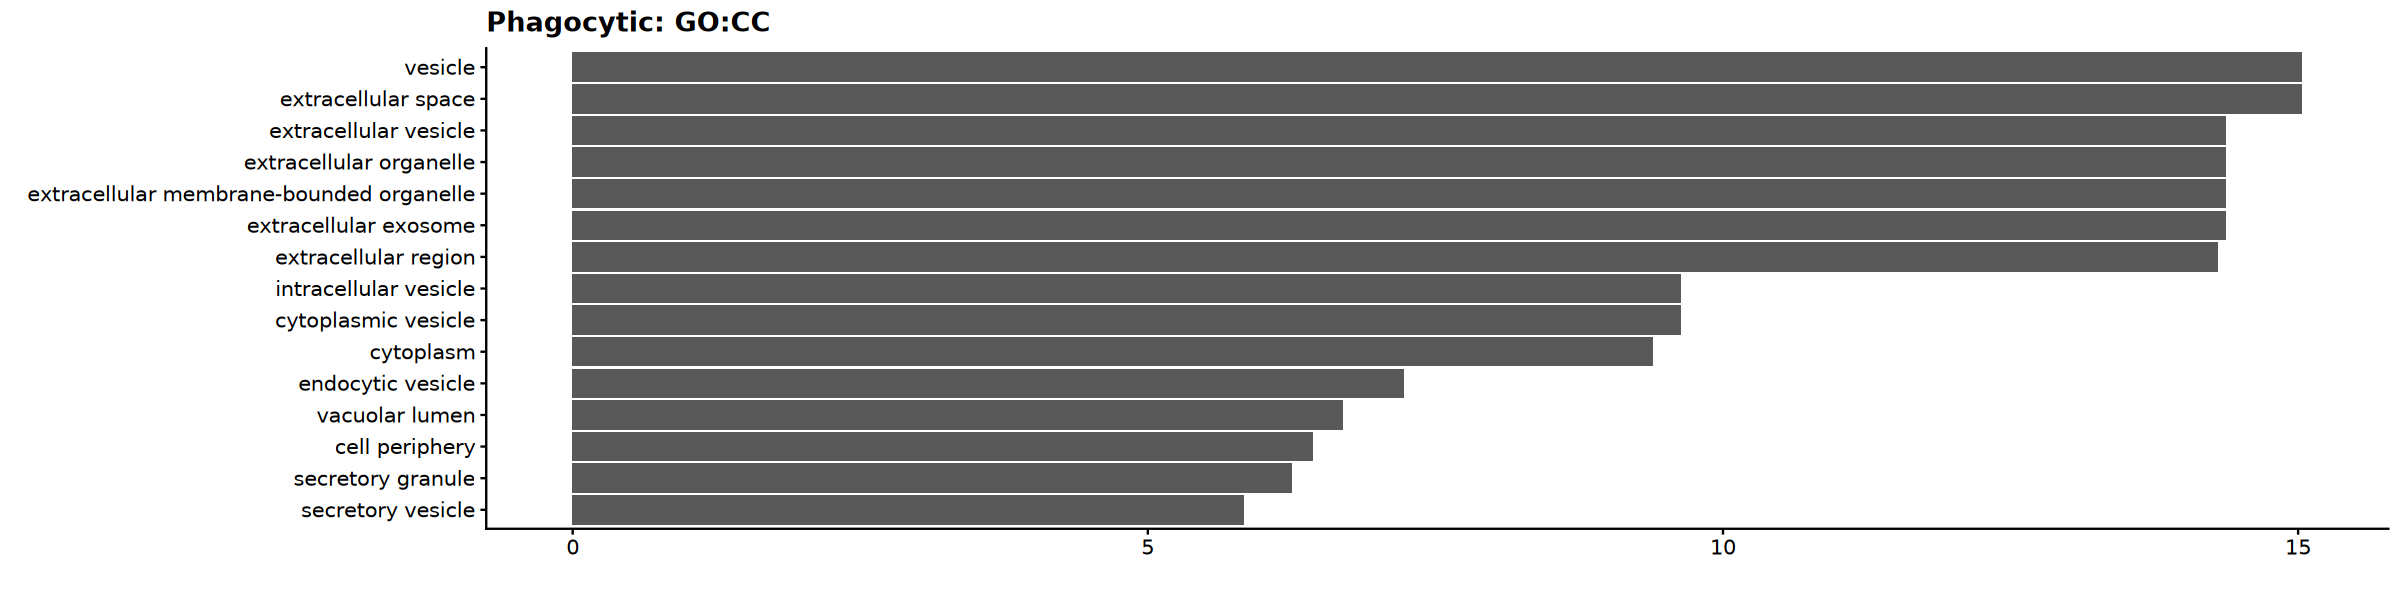

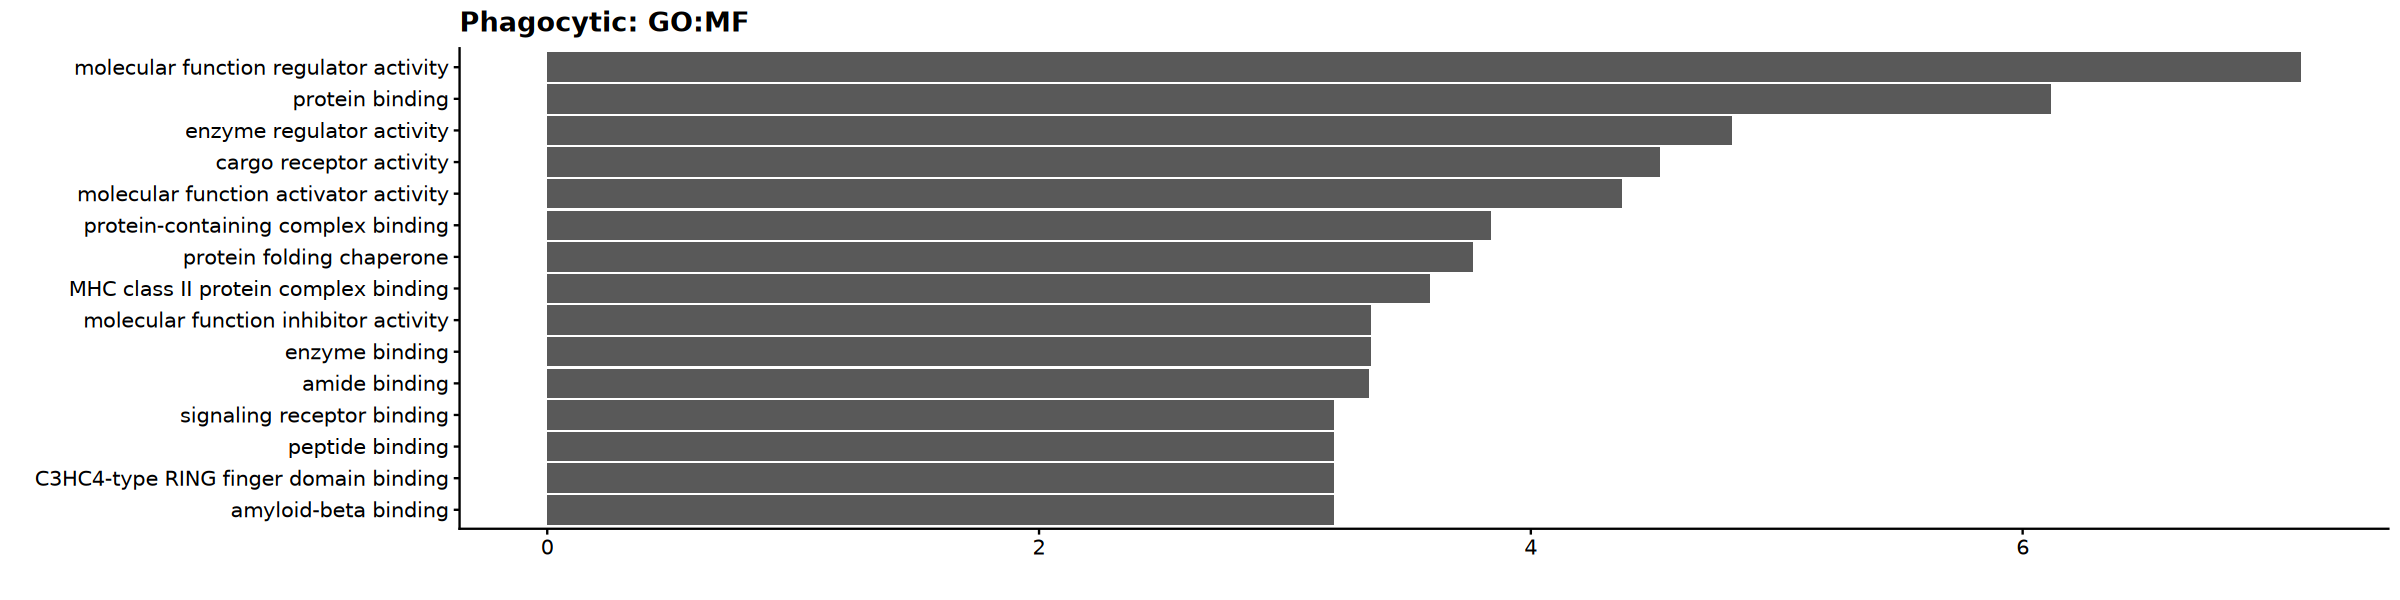

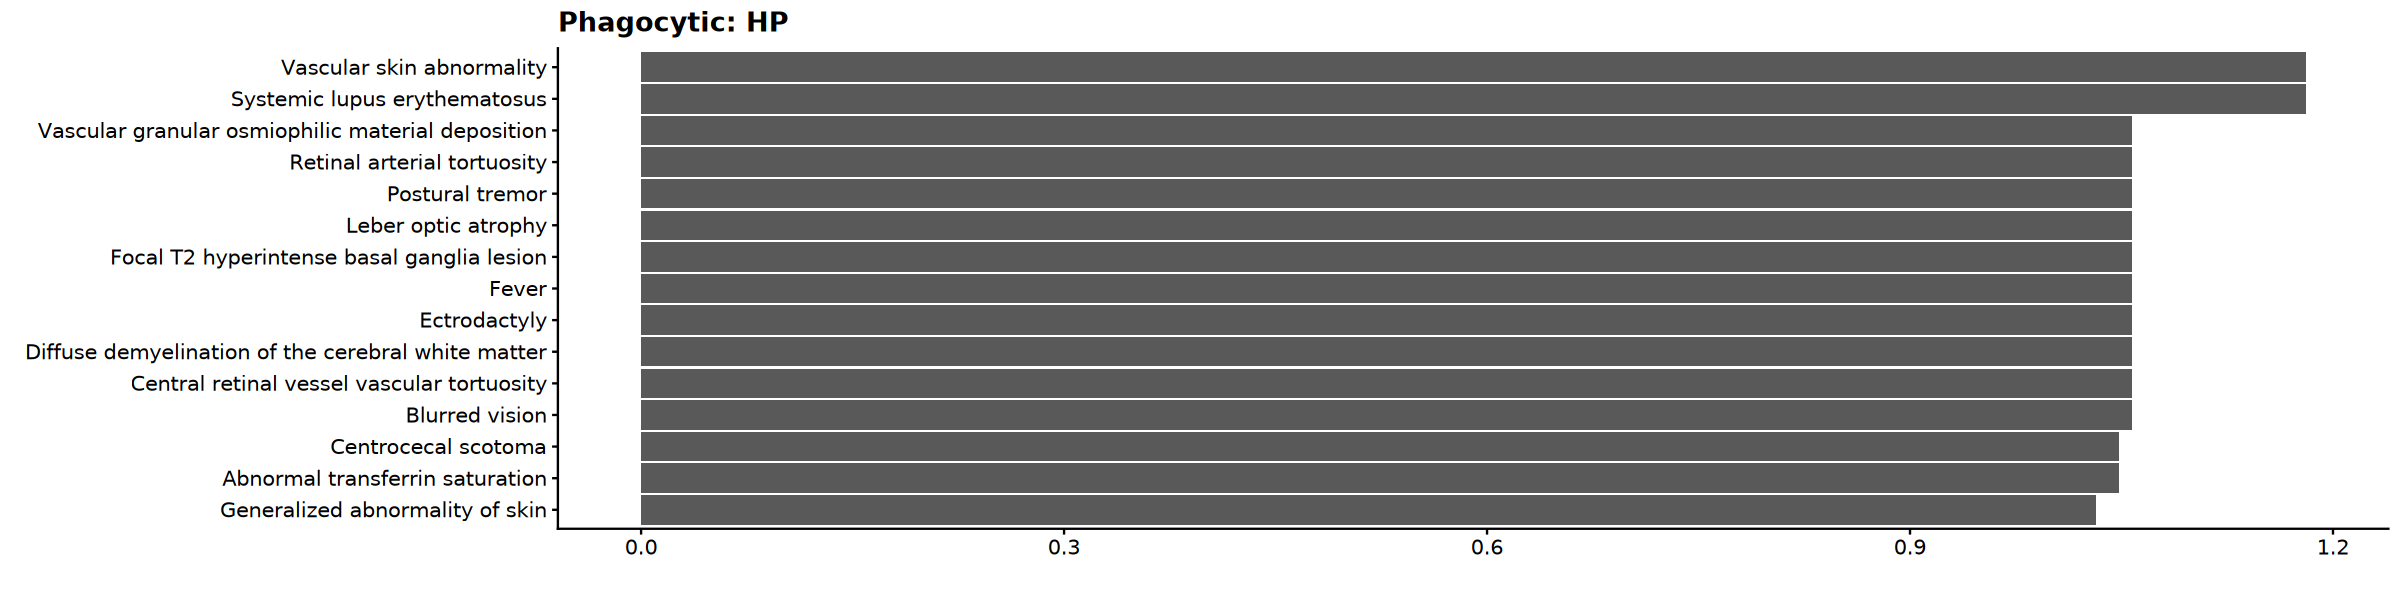

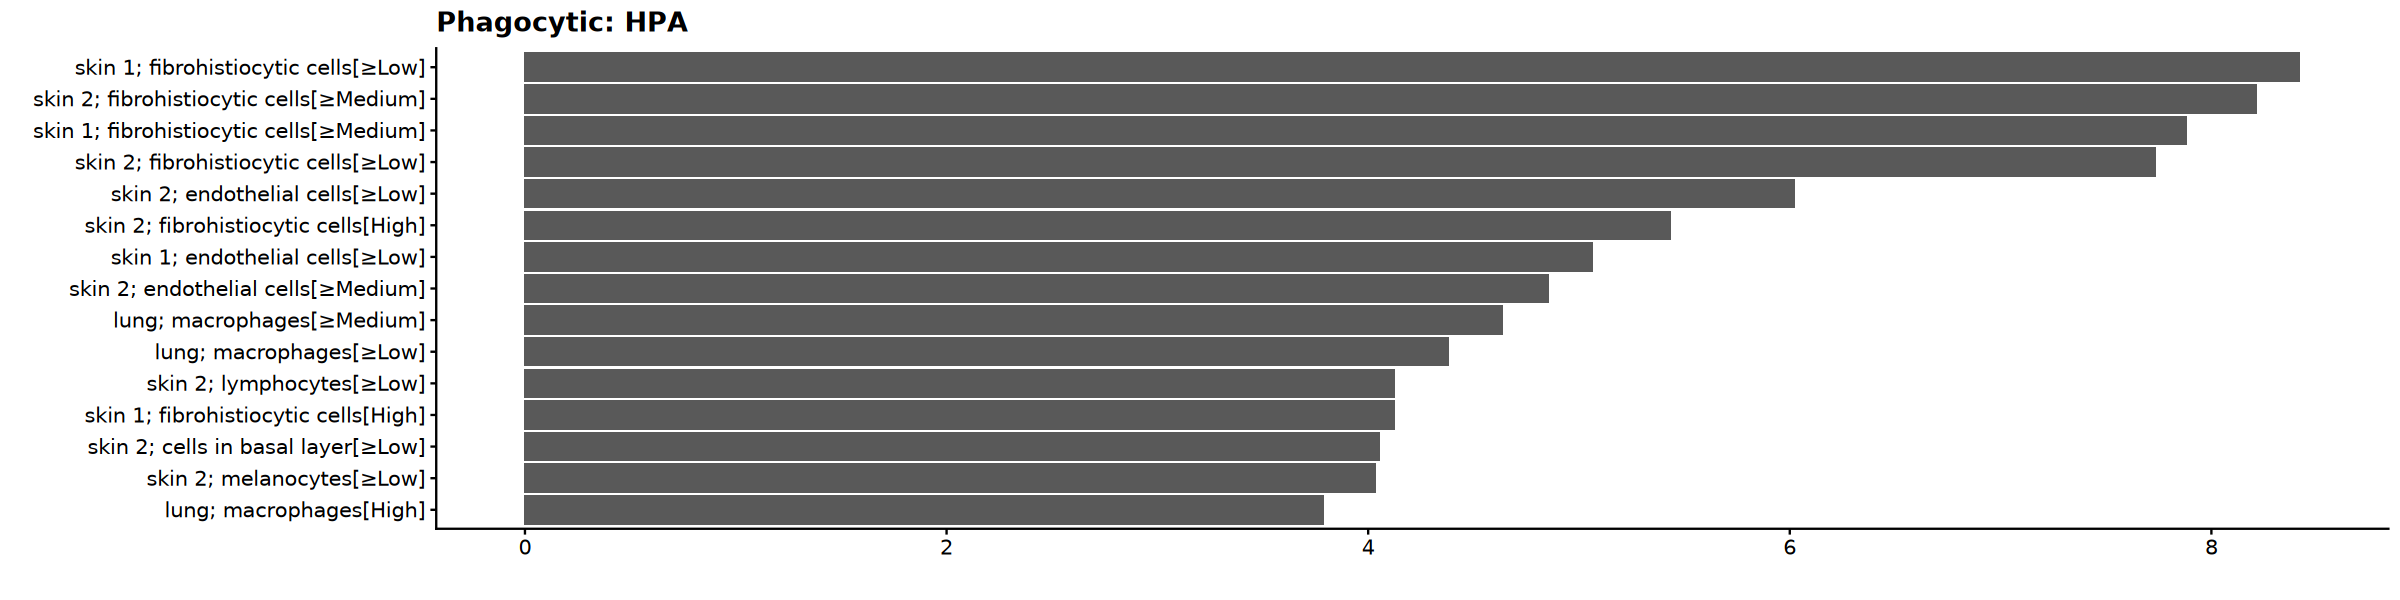

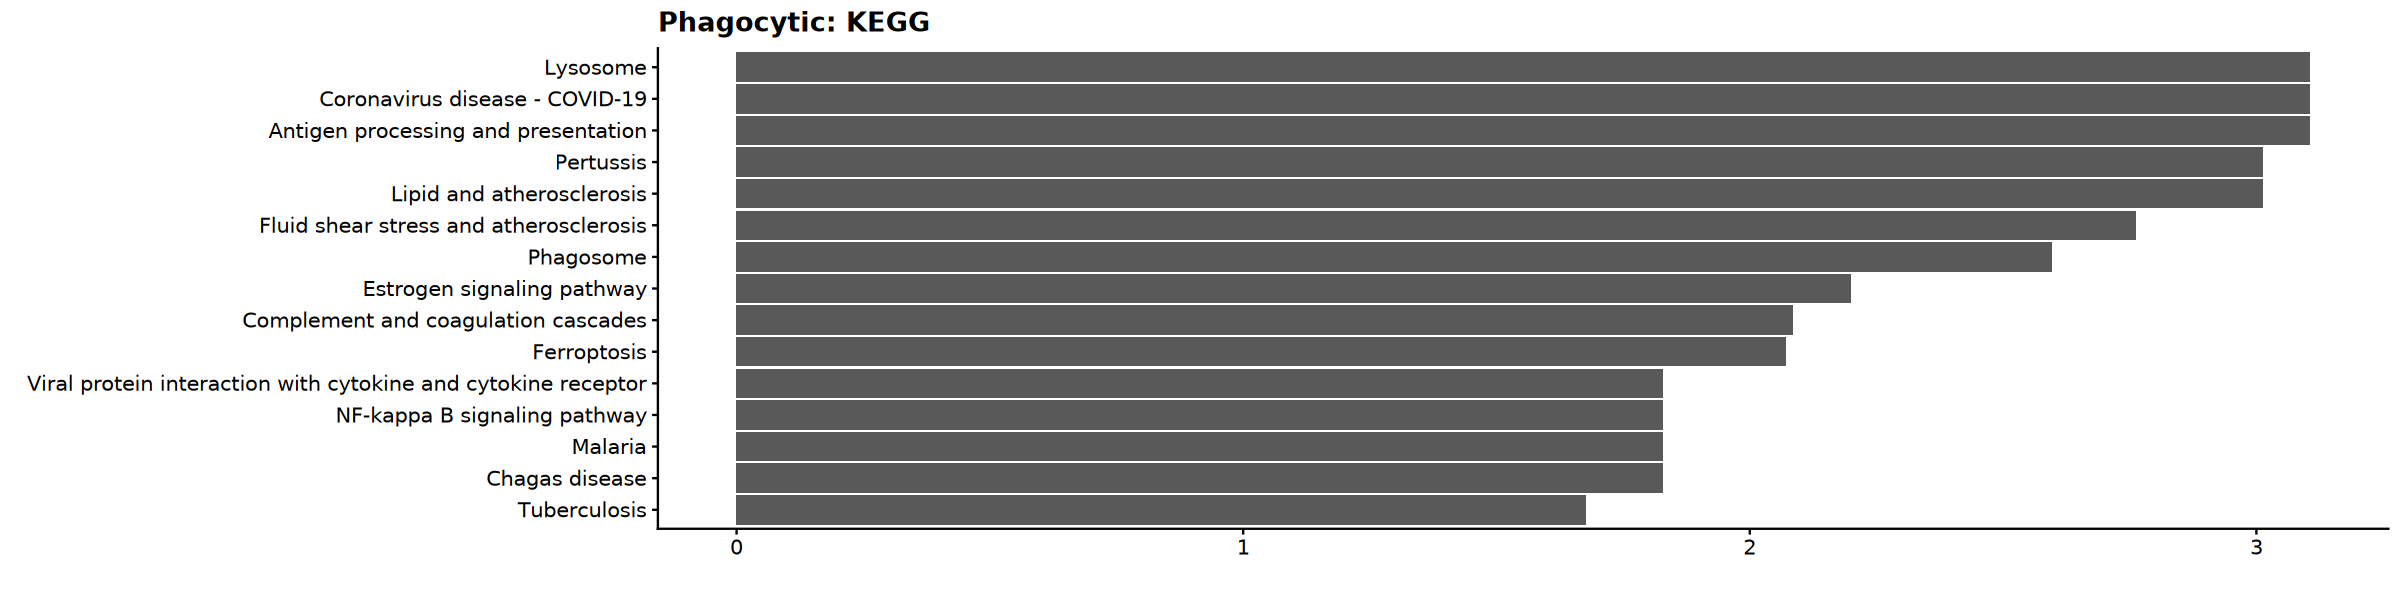

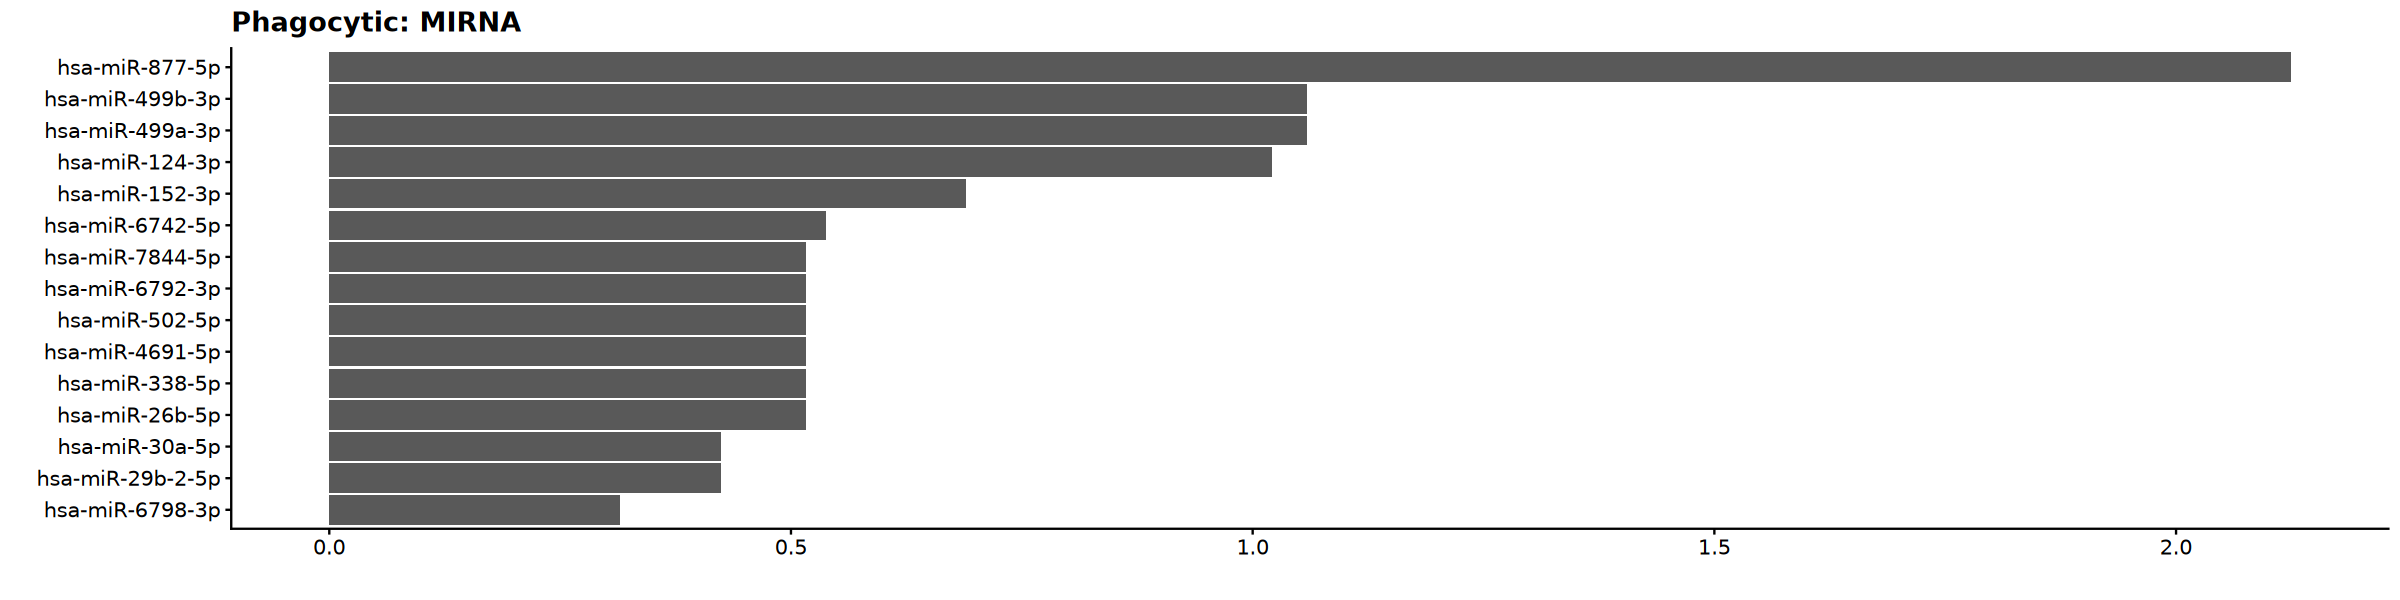

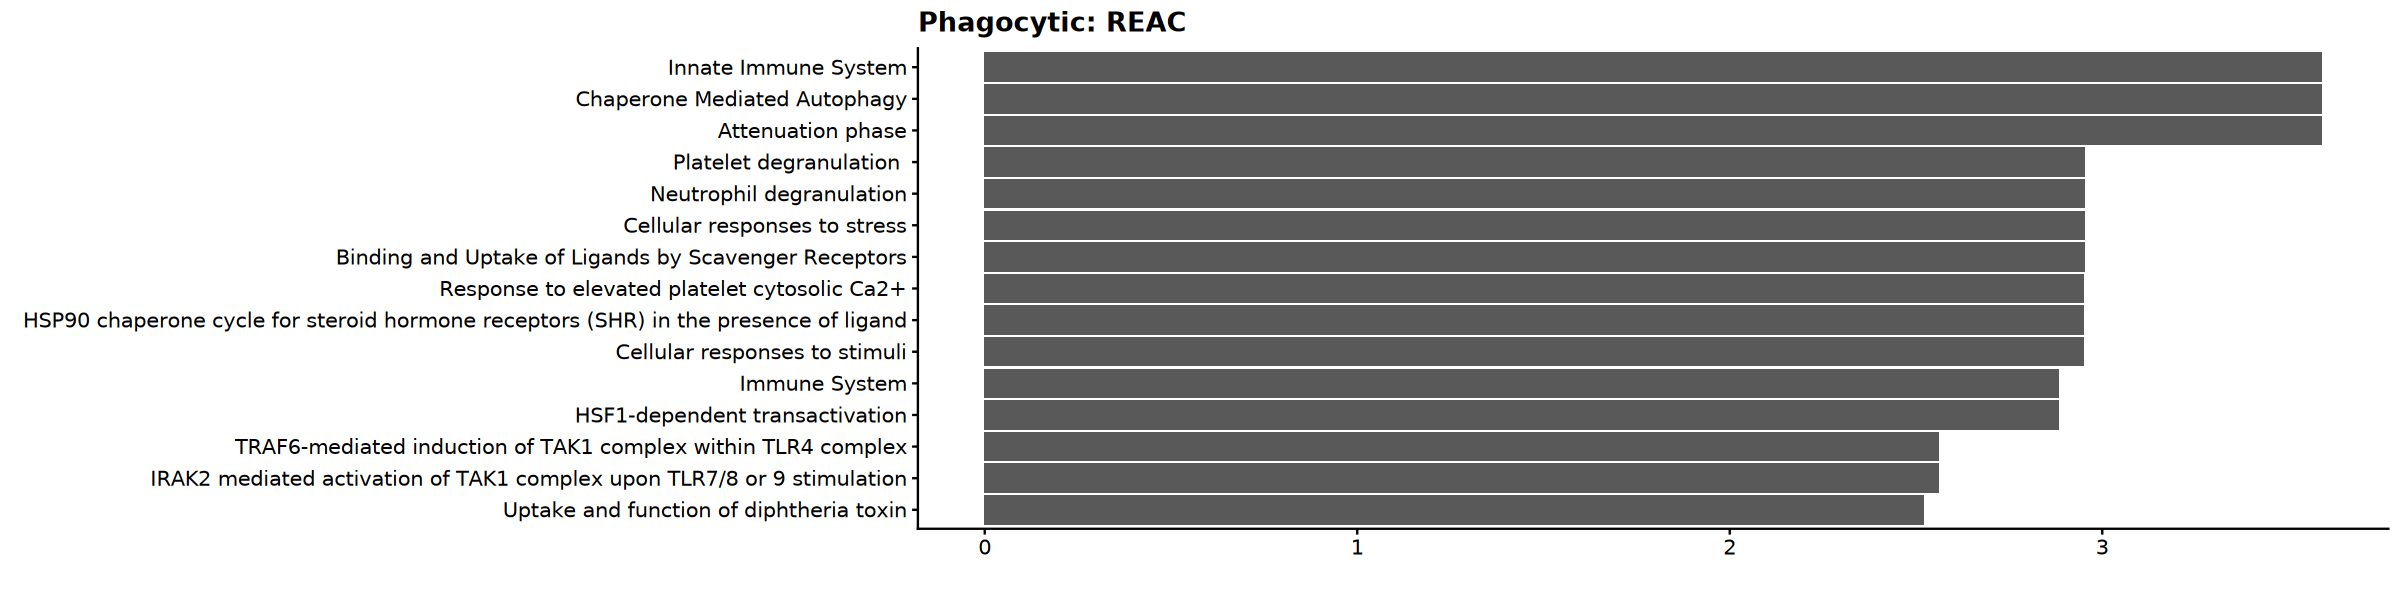

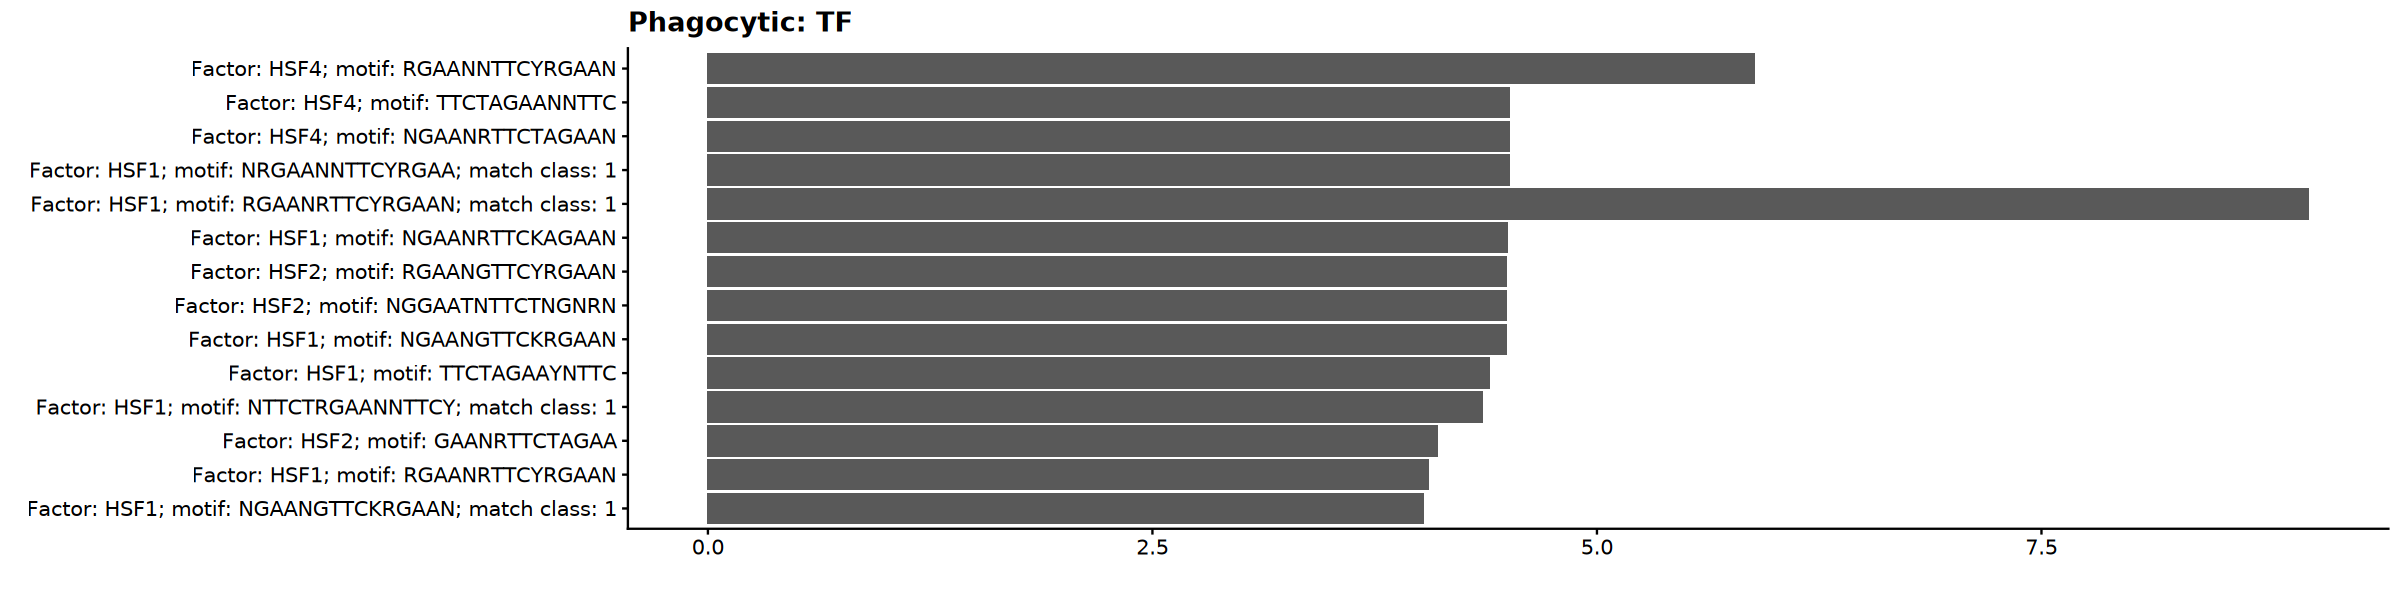

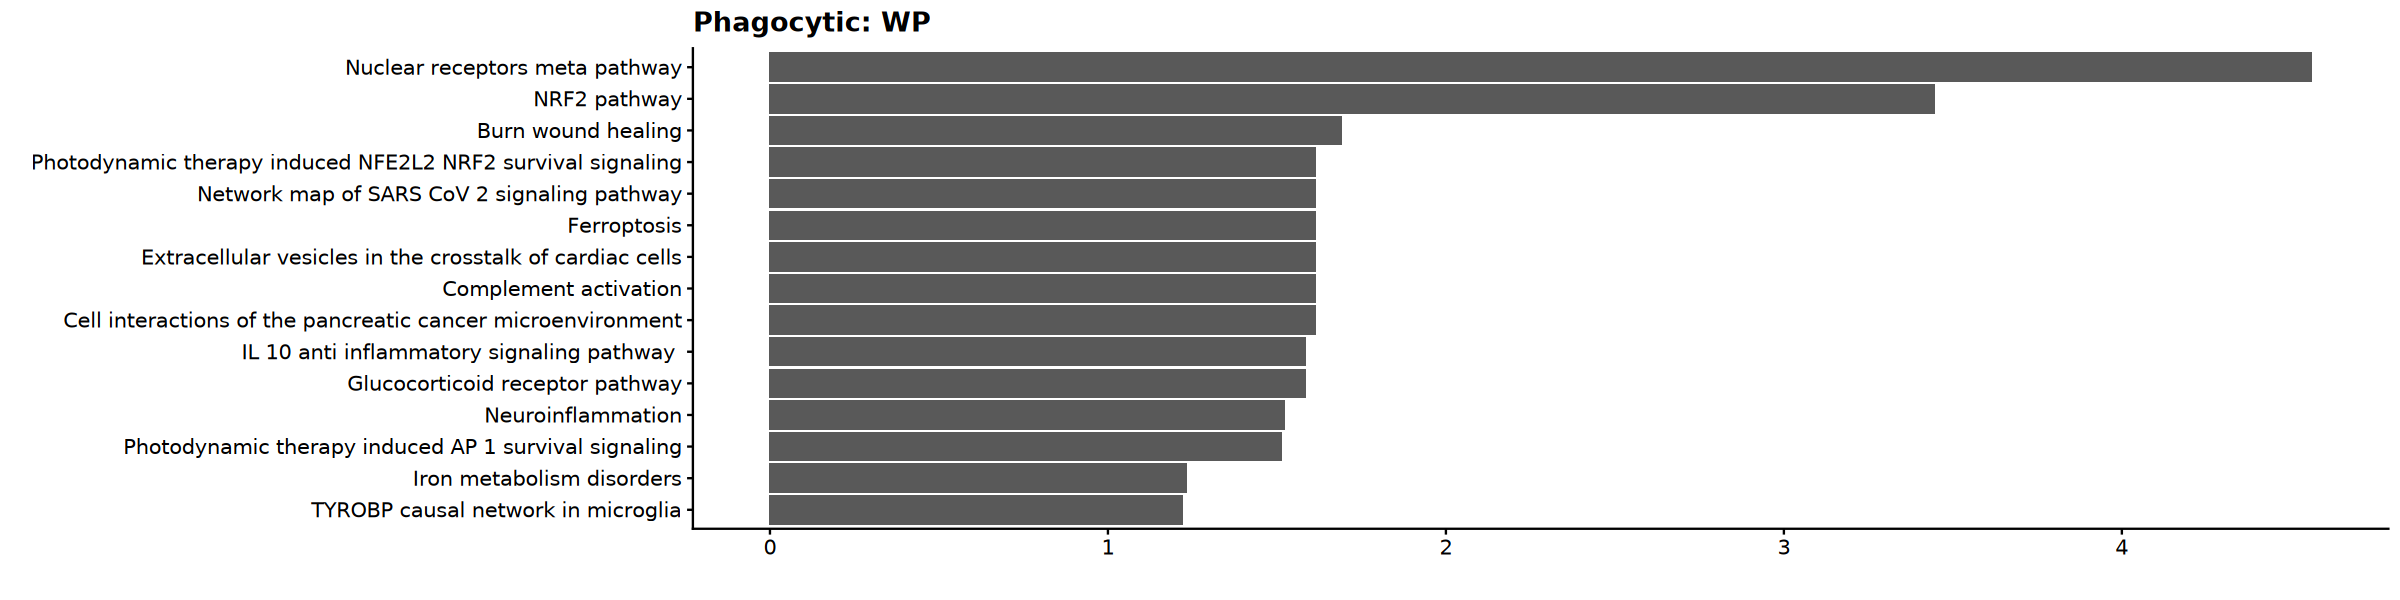

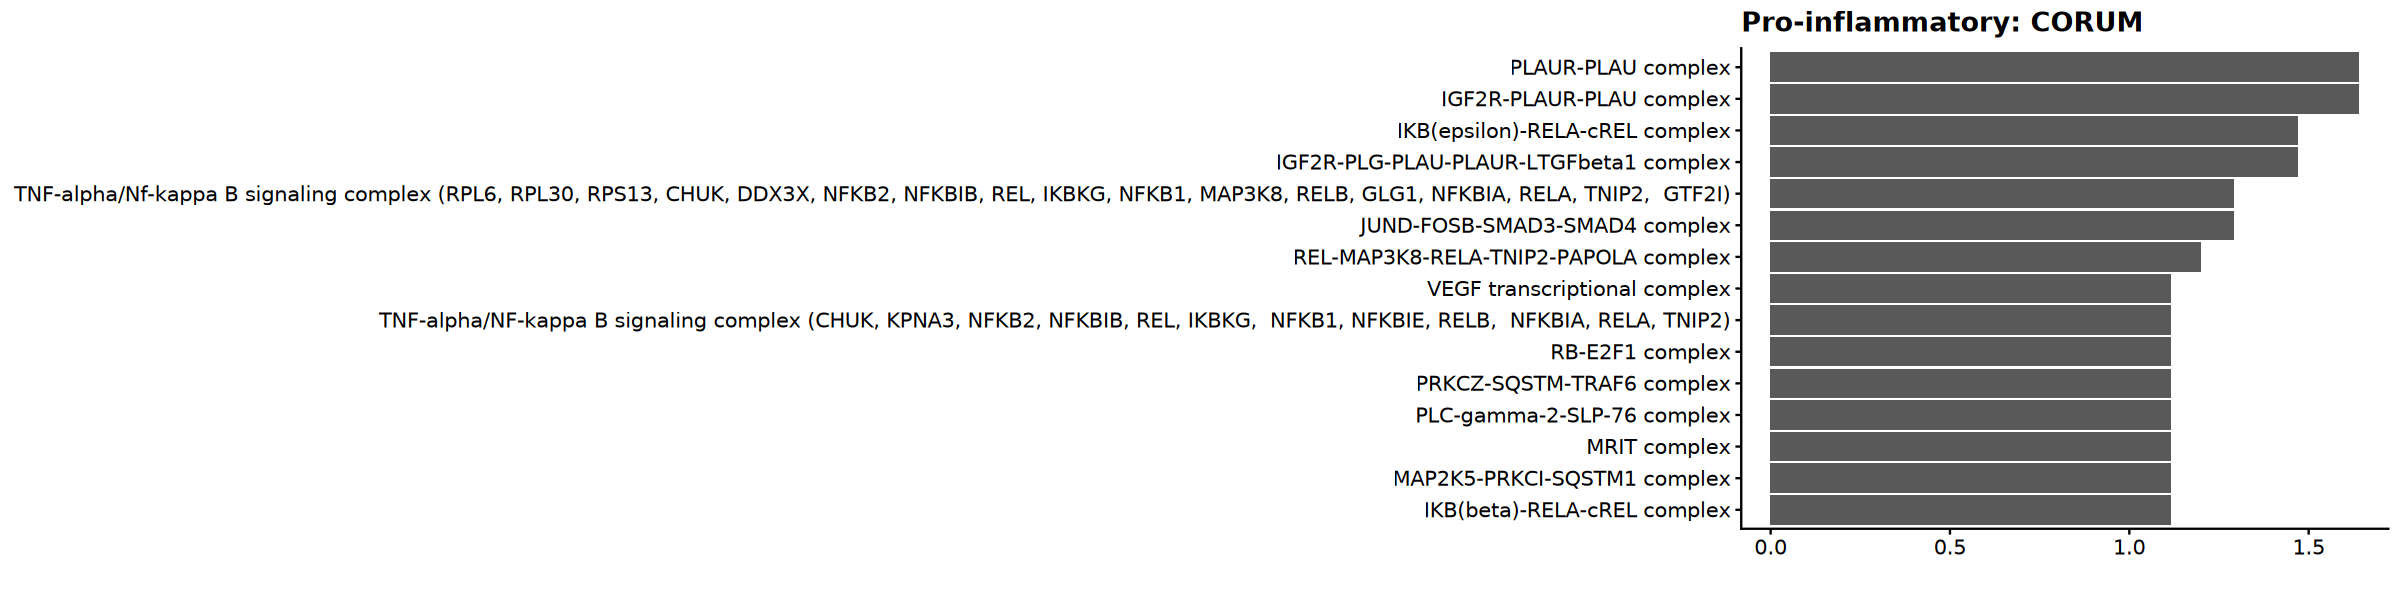

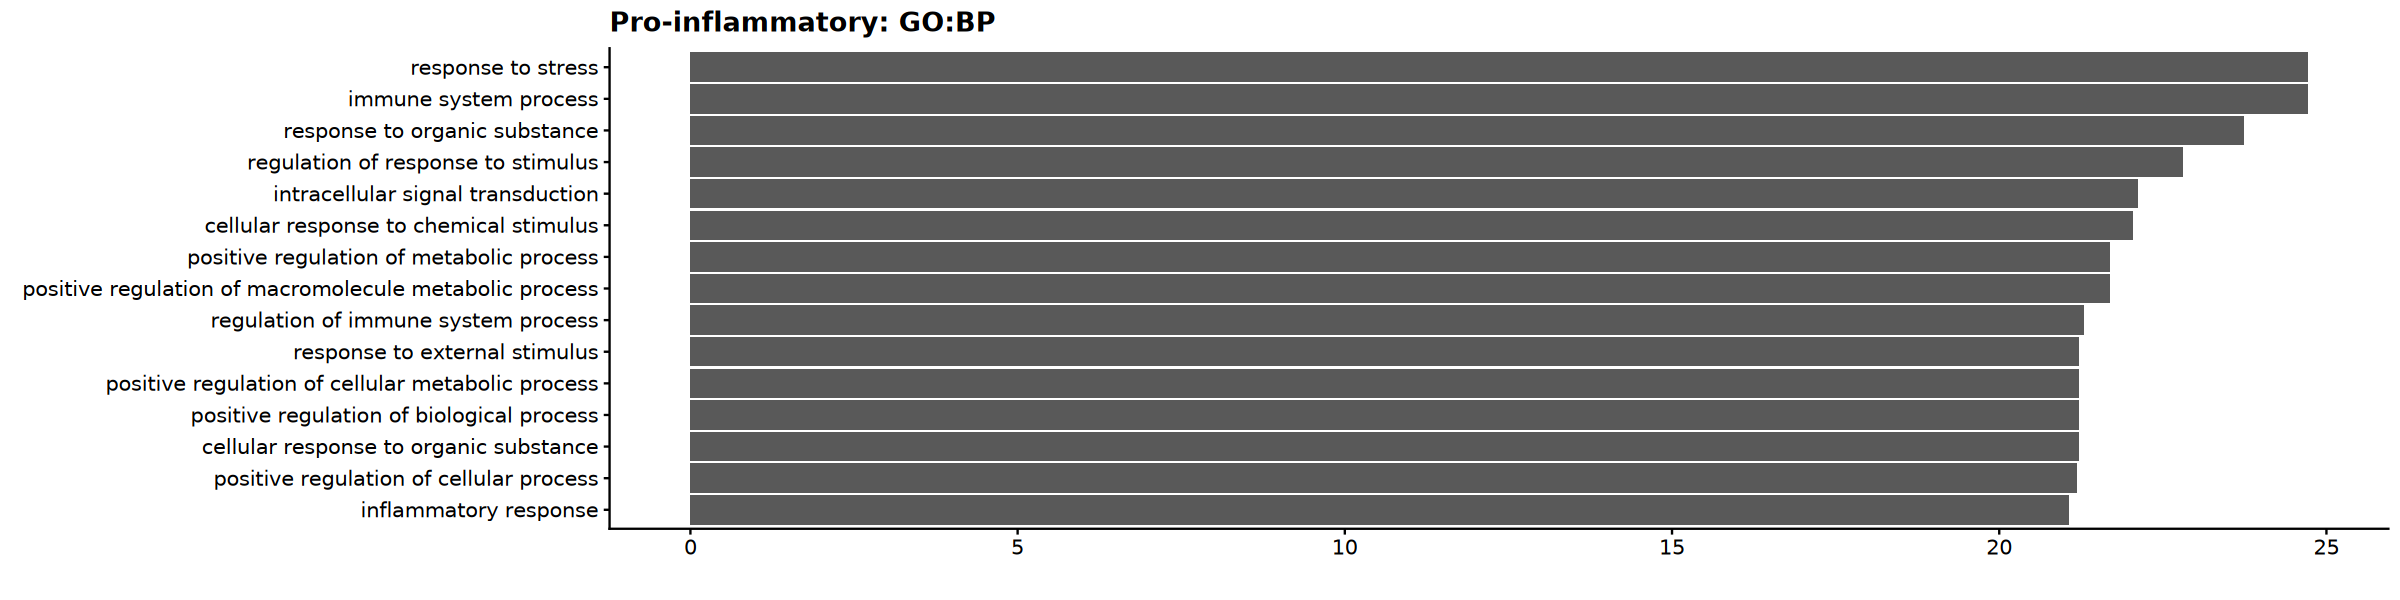

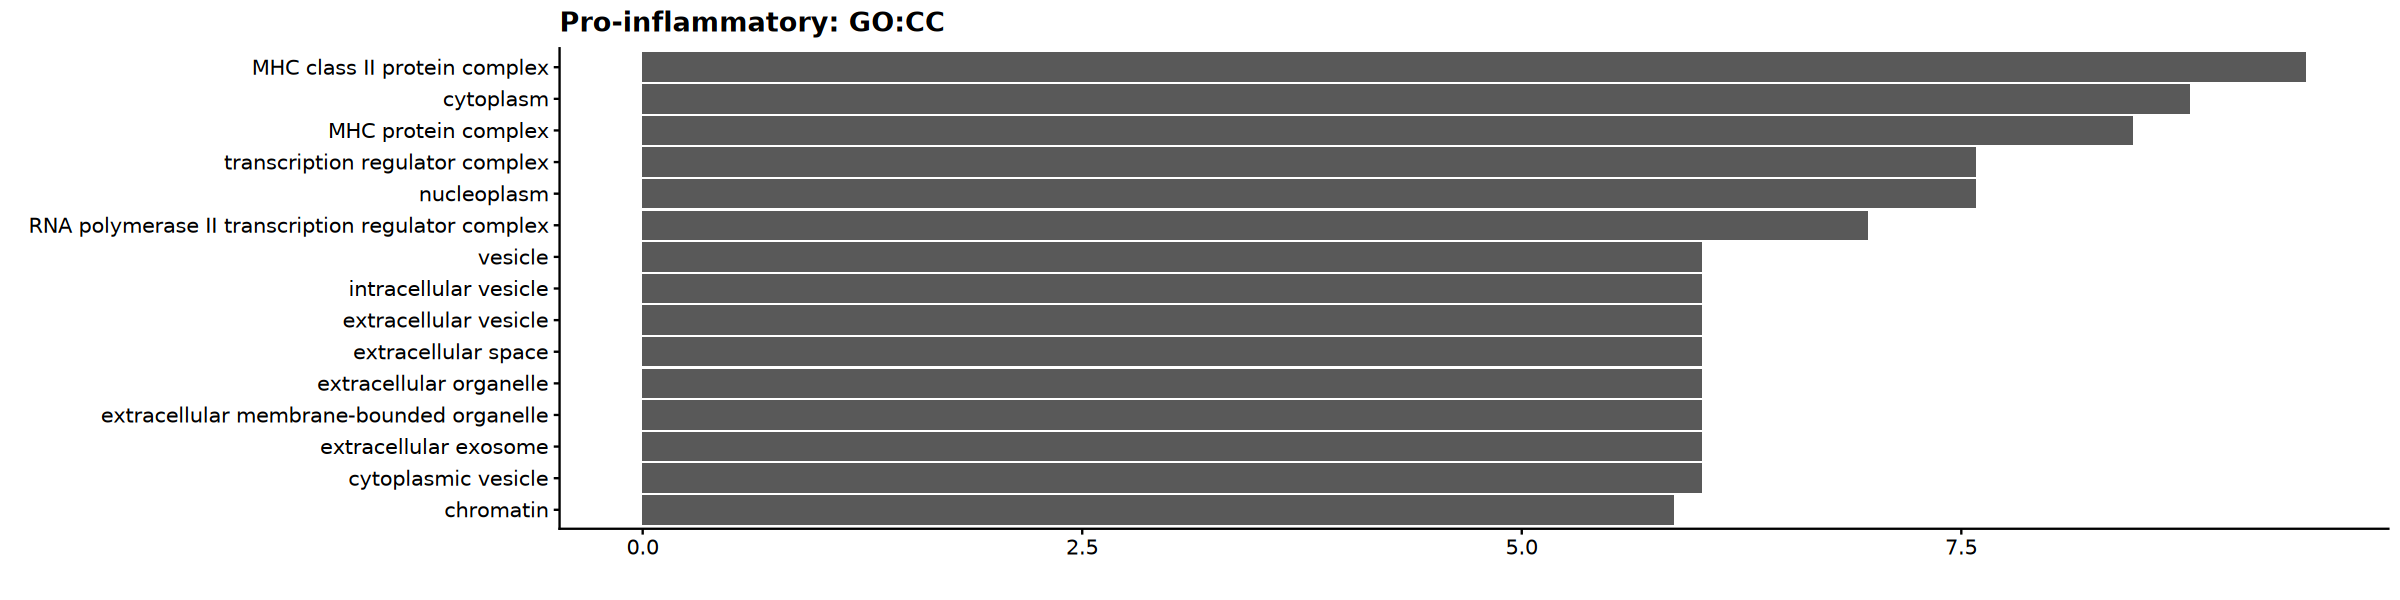

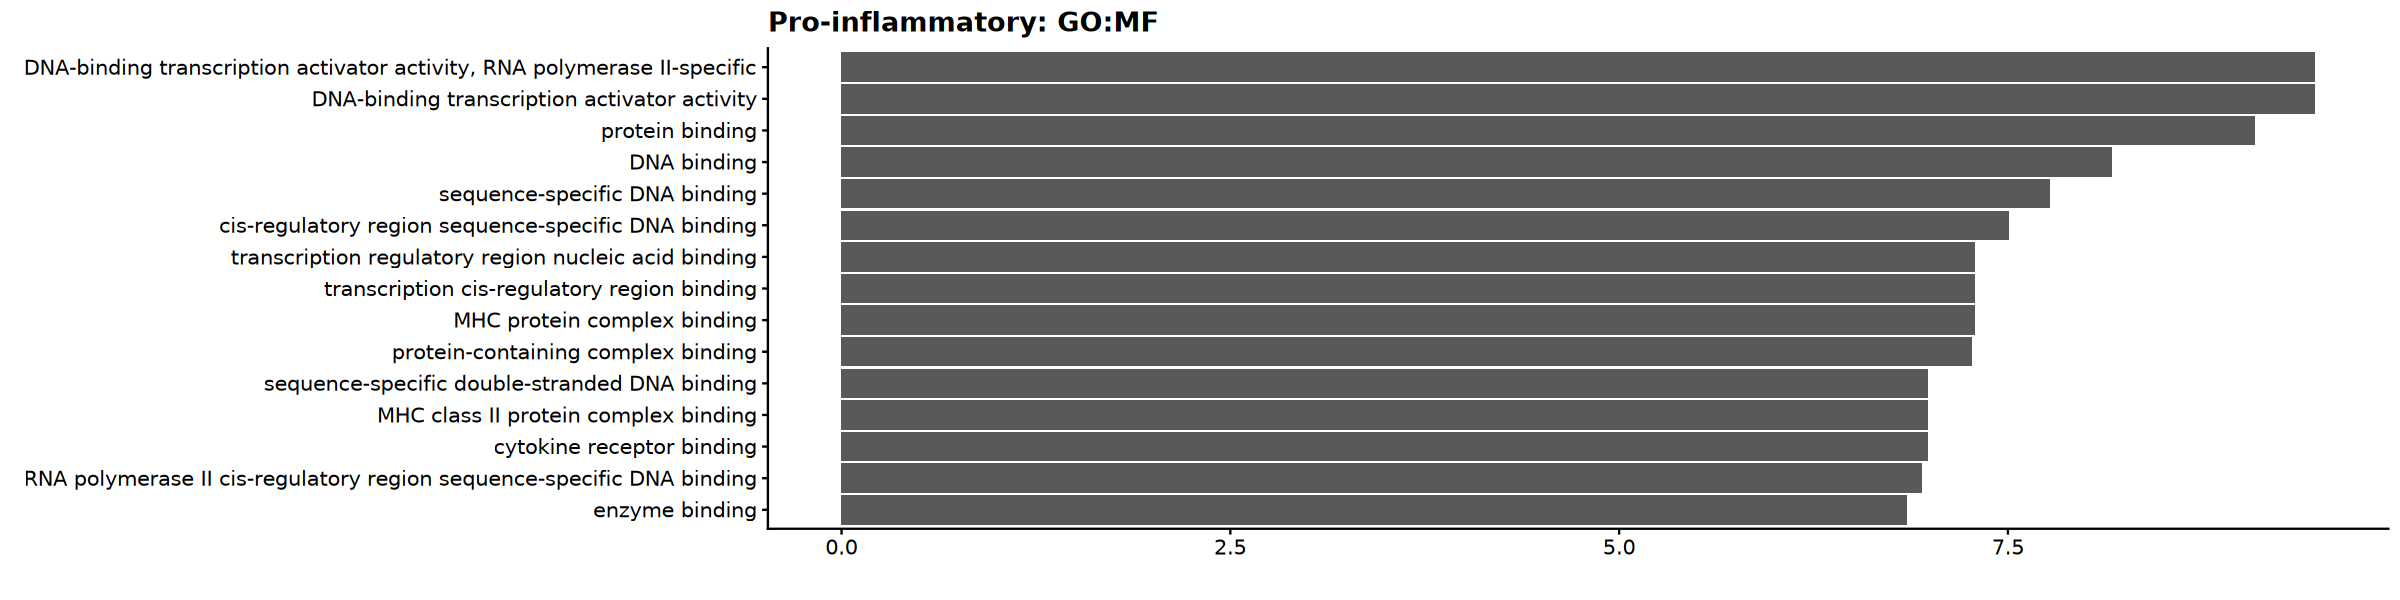

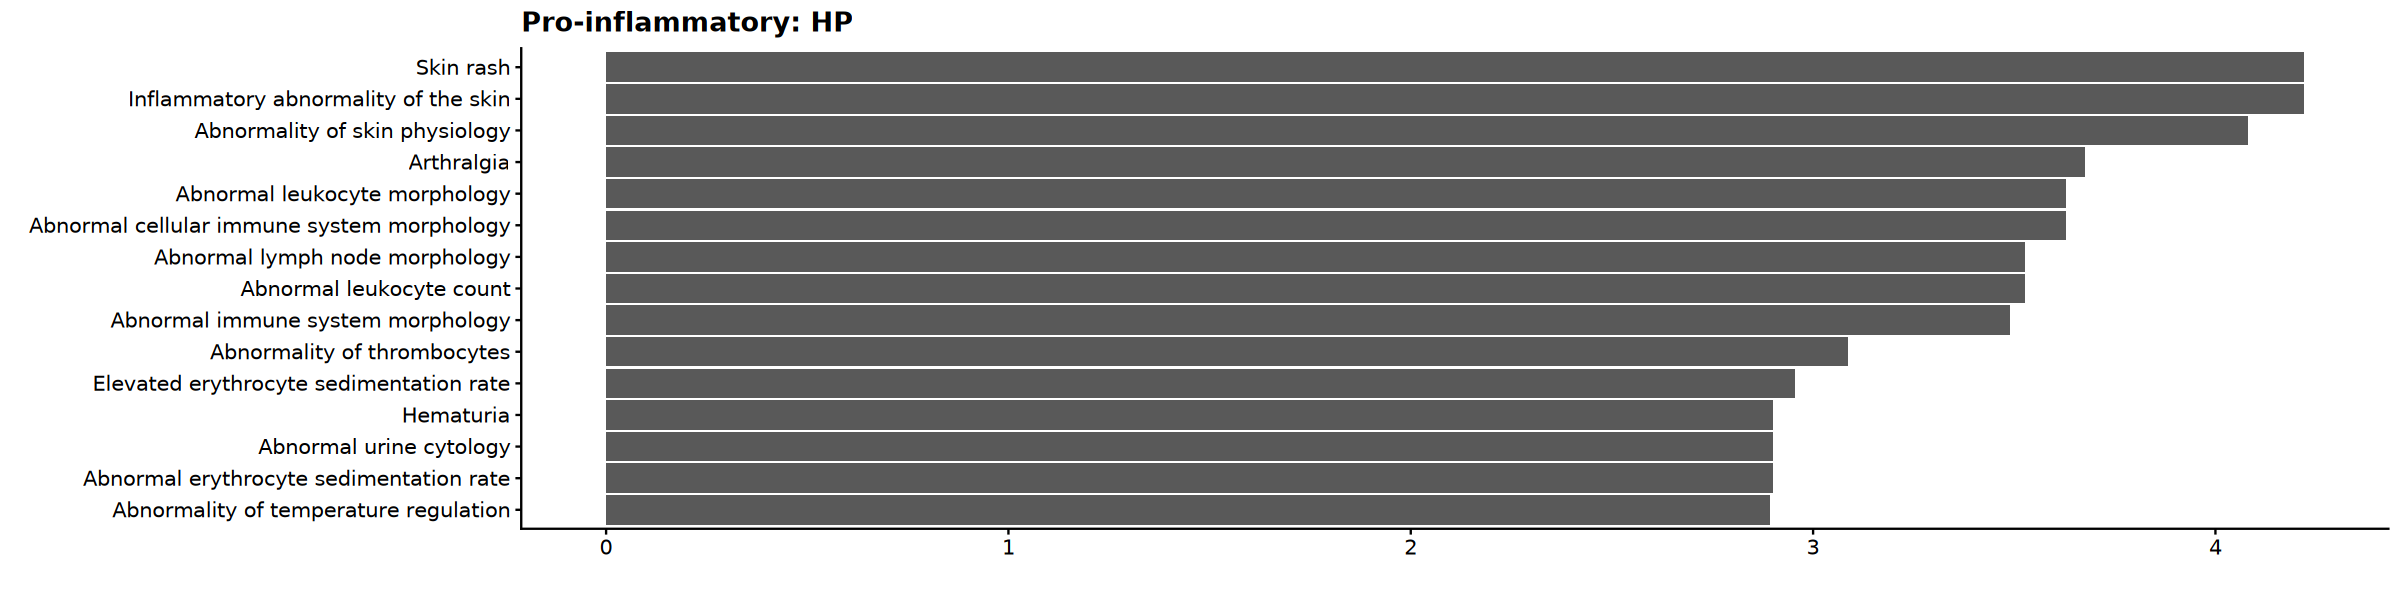

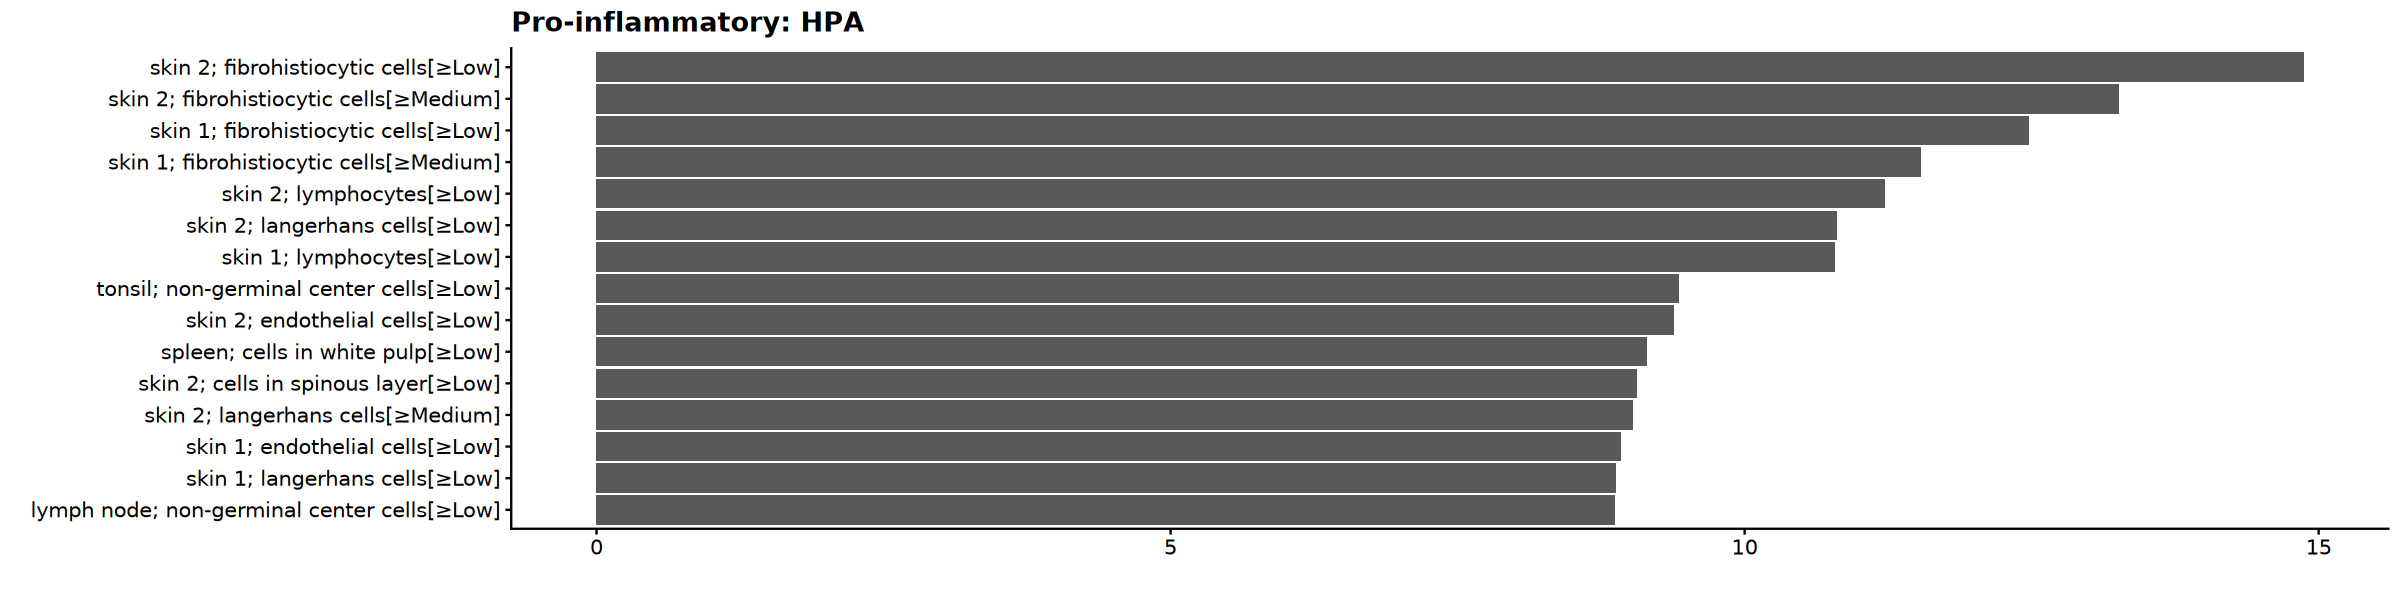

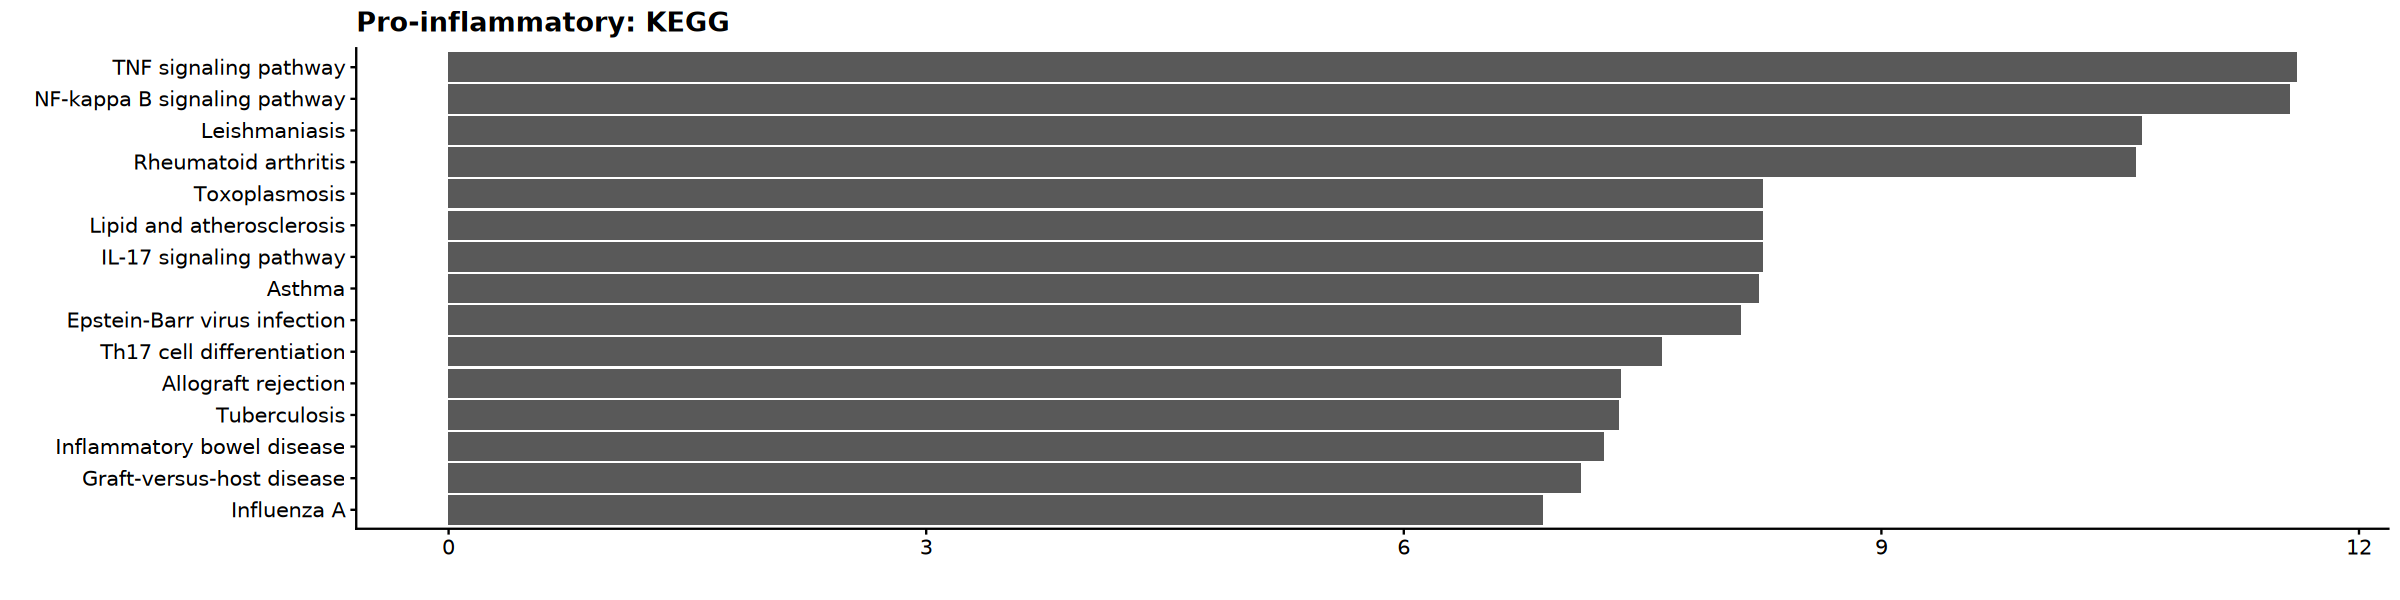

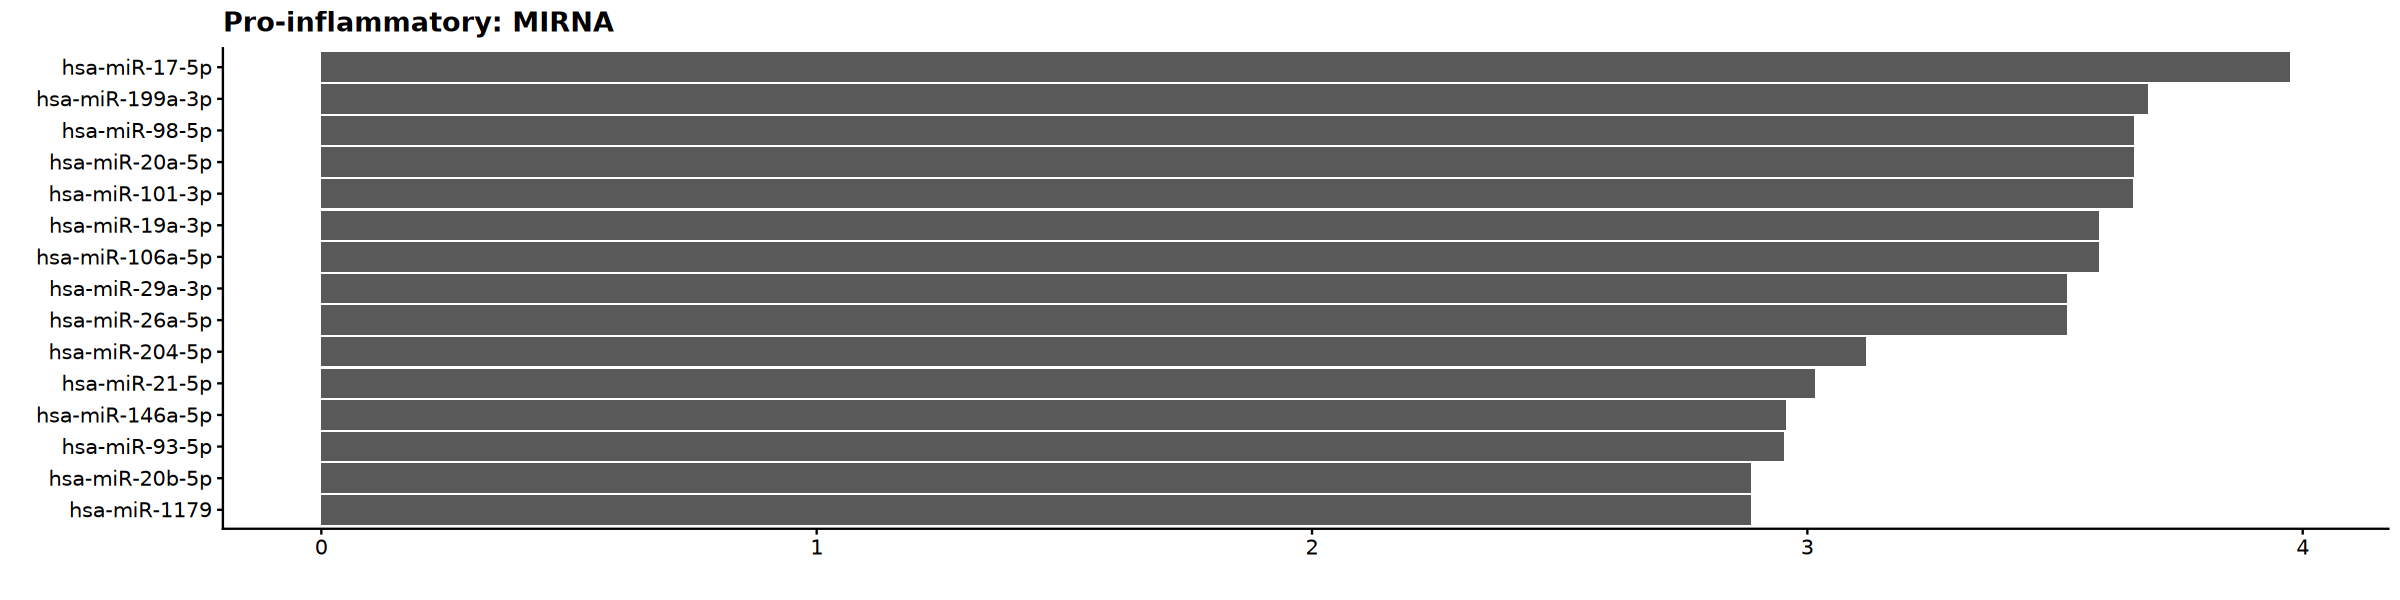

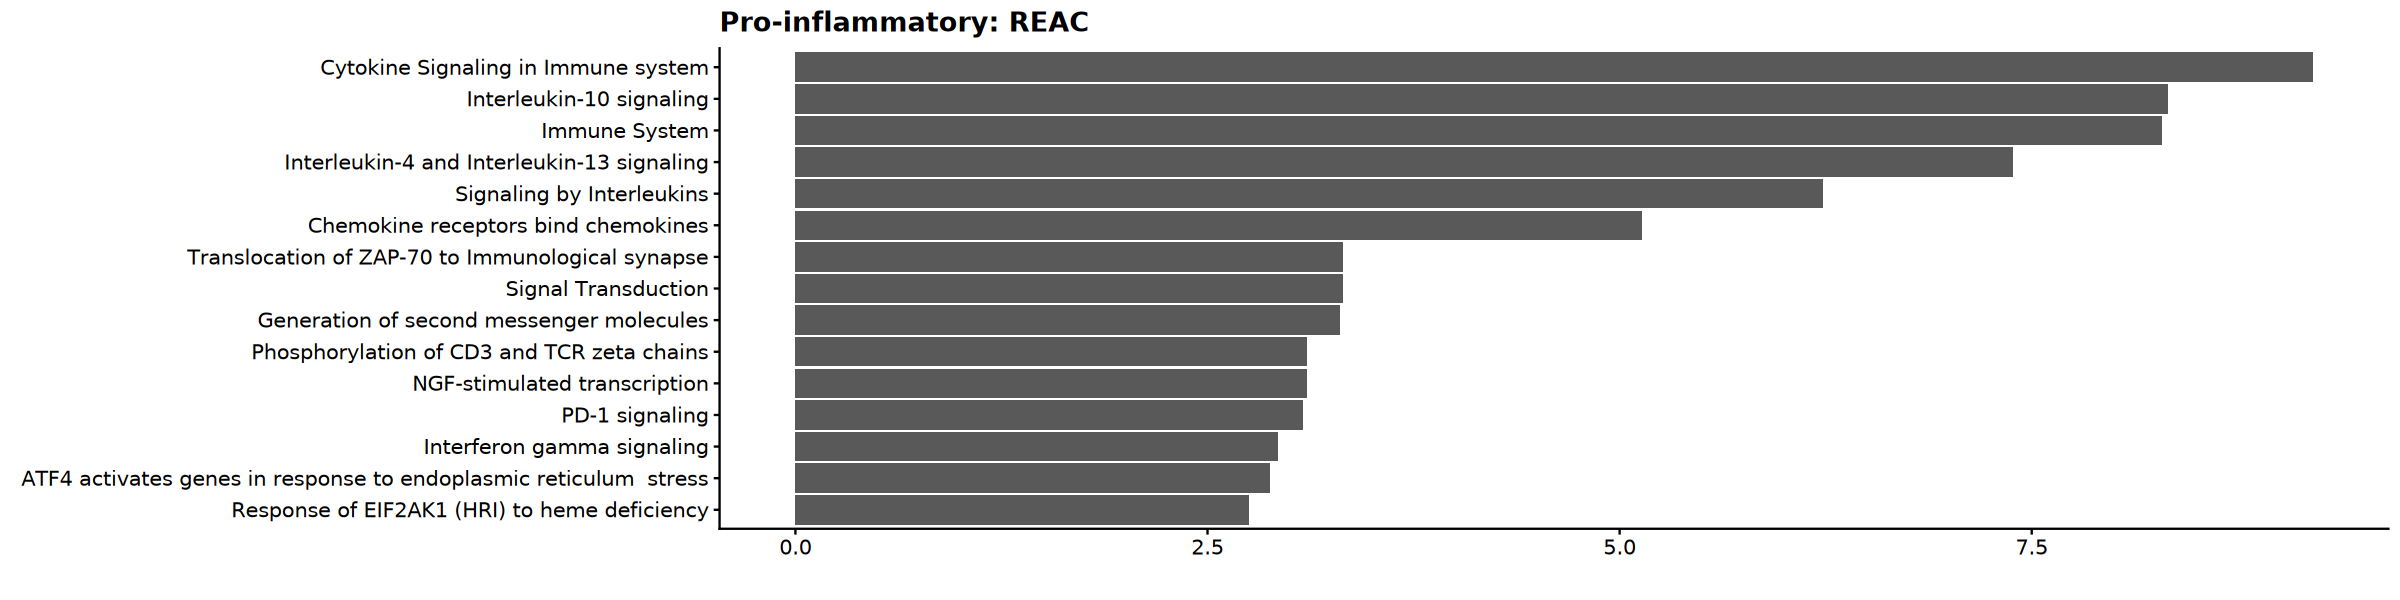

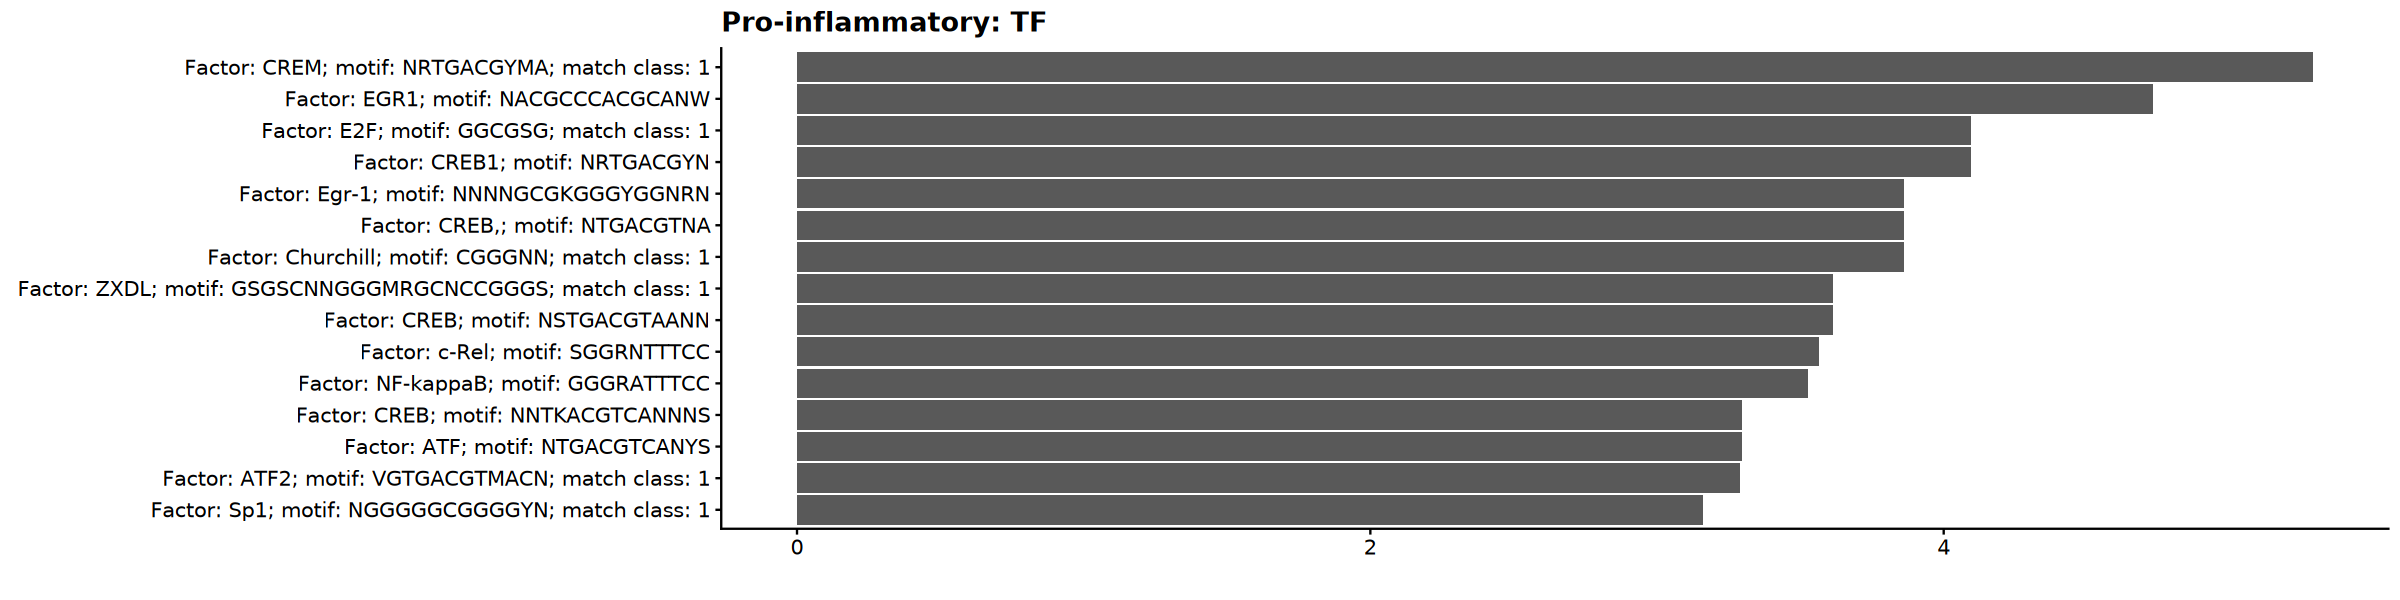

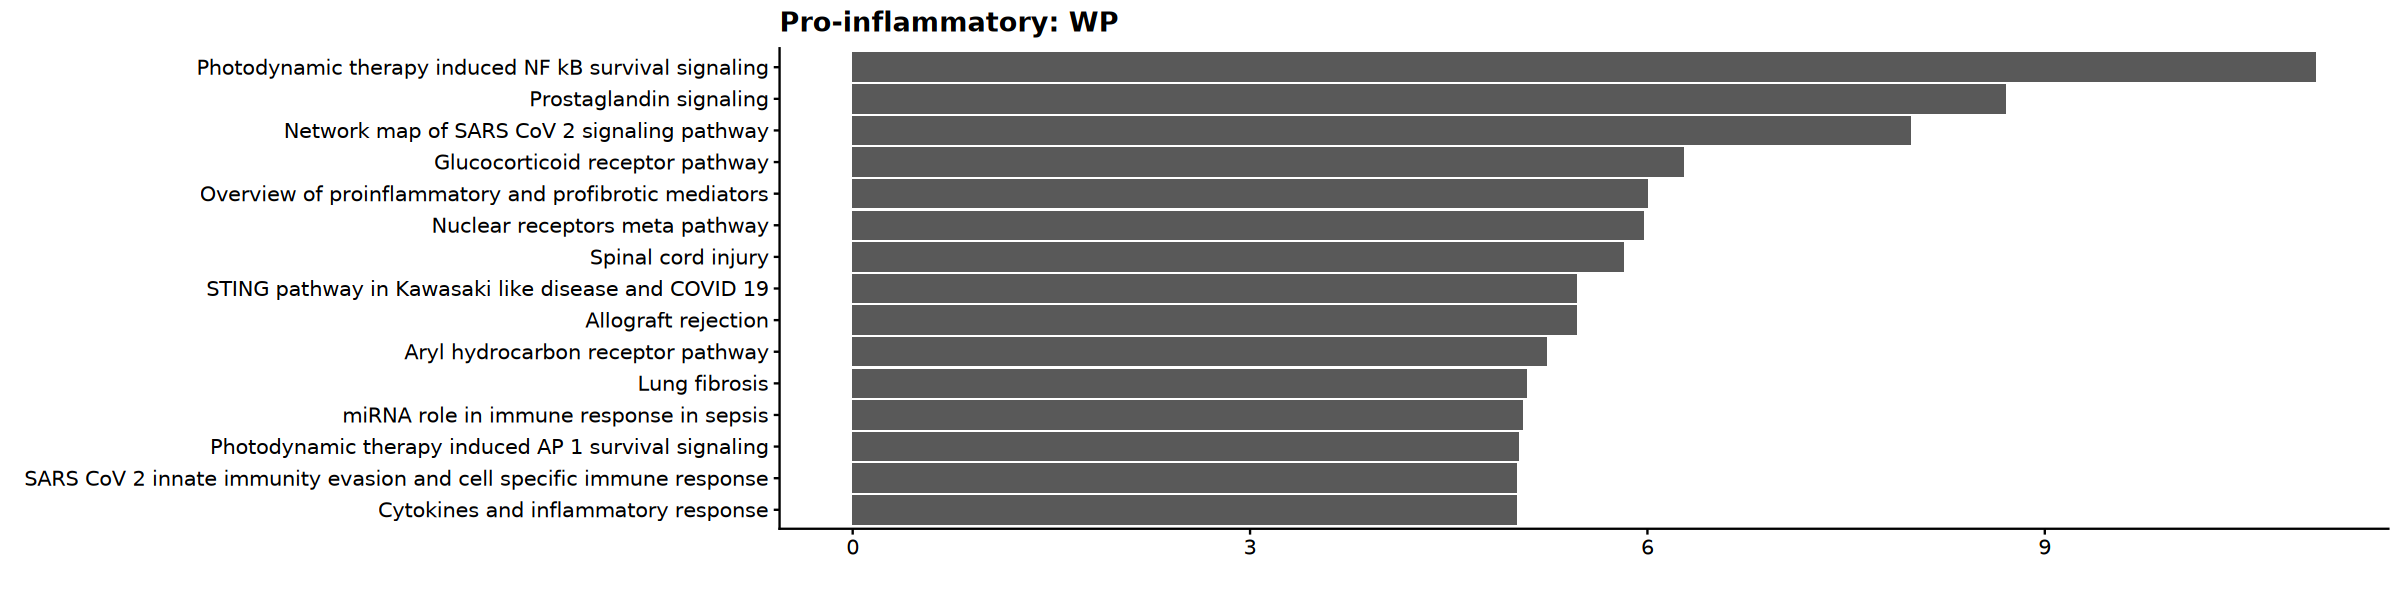

In [8]:
# plot top15 terms based on p-values
options(repr.plot.height = 5, repr.plot.width = 20)

for(c in unique(df_go$cluster)){
    for(s in unique(df_go$source)){
        
        df_go_sub <- df_go %>%
            subset(cluster == c & source == s) %>%
            mutate(p_value = -log10(p_value)) %>%
            slice_max(n = 15, order_by = p_value, with_ties = FALSE)
        
        p <- ggplot(data=df_go_sub, aes(x = reorder(term_name, p_value), y = p_value)) +
                geom_bar(stat = "identity") +
                coord_flip() +
                xlab("") + ylab("") +
                theme_cowplot() +
                ggtitle(glue::glue("{c}: {s}"))
    
        print(p)
    
    }
}

In [47]:
get_ht <- function(s, df_go){
    df_go_sub <- df_go %>%
                subset(source == s) %>%
                mutate(p_value = -log10(p_value)) %>%
                dplyr::select(-source) %>%
                group_by(cluster) %>%
                slice_max(n = 10, order_by = p_value, with_ties = FALSE) %>%
                tidyr::pivot_wider(names_from = cluster, values_from = p_value, values_fill = 0) %>%
                textshape::column_to_rownames("term_name")

#    quantile(m, probs = c(.25, .5, .75))
#      max(df_go_sub)*0.85
    
        col_fun <- colorRamp2(seq(from = min(df_go_sub), to = quantile(as.matrix(df_go_sub), 0.9), length = 9), 
                         RColorBrewer::brewer.pal(name = "Greens", n = 9))

        ht <- Heatmap(as.matrix(df_go_sub),
                      name = s,
                      col = col_fun,
                      rect_gp = gpar(col = "black", lwd = 0.2),
                      column_title = s,
                      row_names_gp = grid::gpar(fontsize = 8)
                     )
    

    return(ht)

}

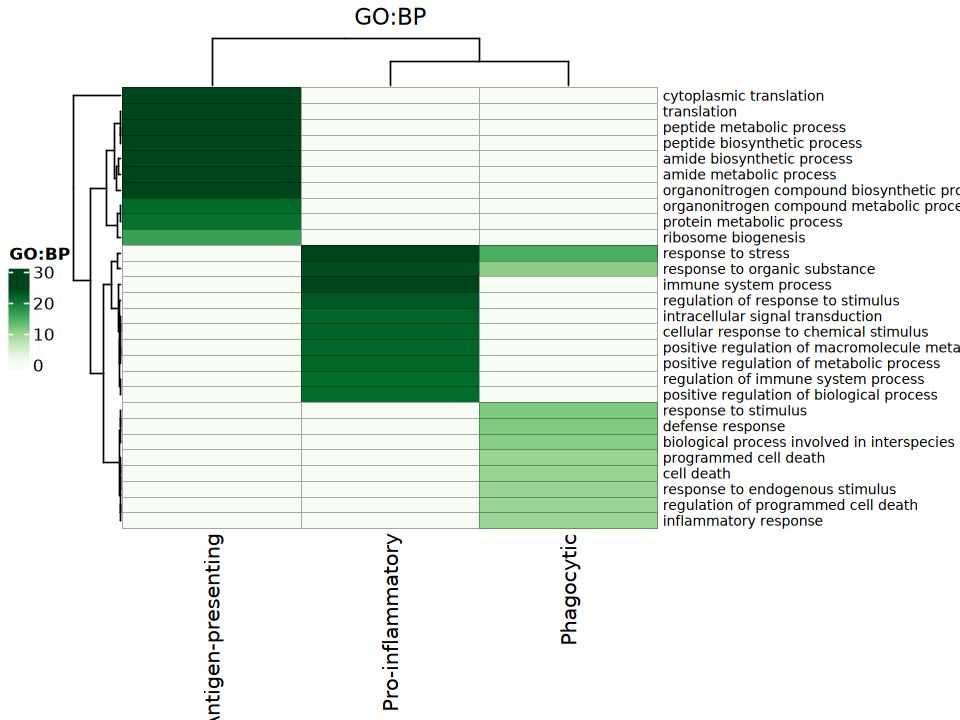

In [48]:
ht <- get_ht(s="GO:BP", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")

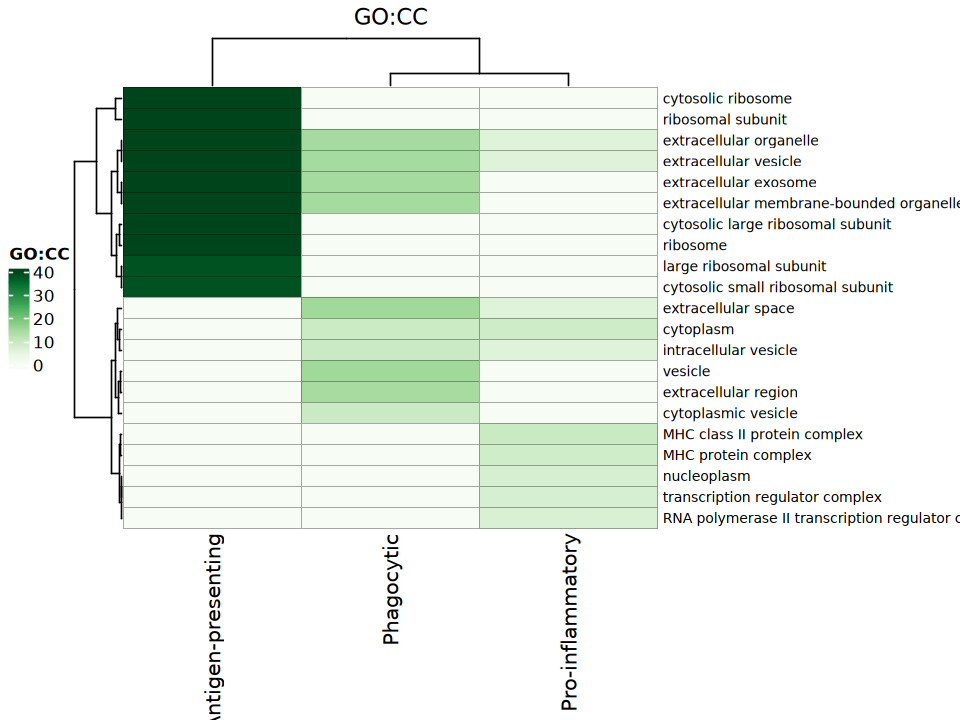

In [49]:
ht <- get_ht(s="GO:CC", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")

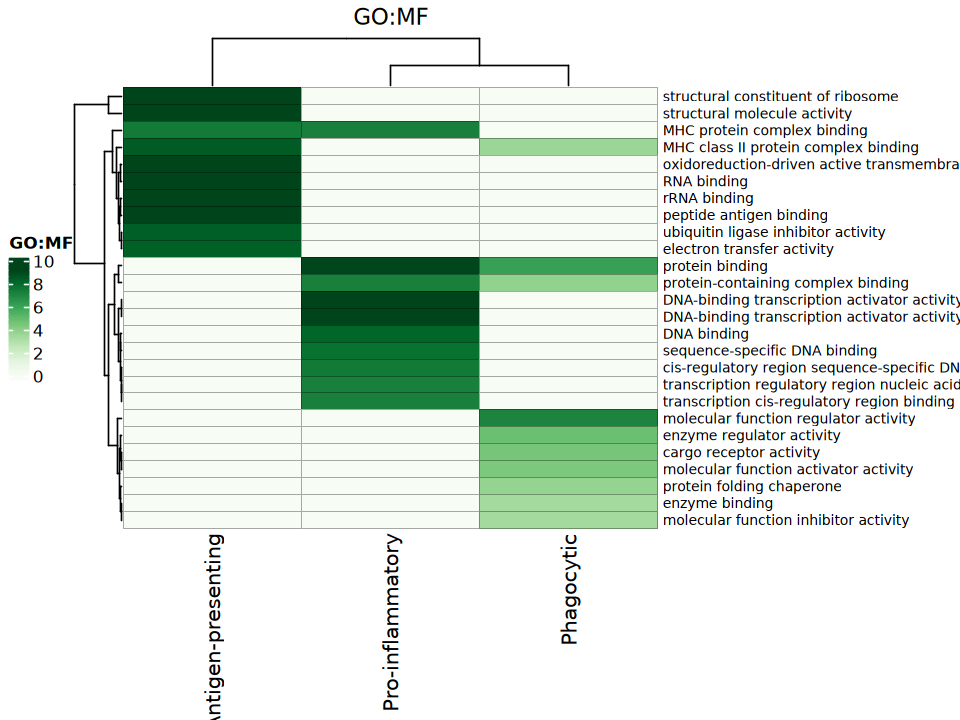

In [50]:
ht <- get_ht(s="GO:MF", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")

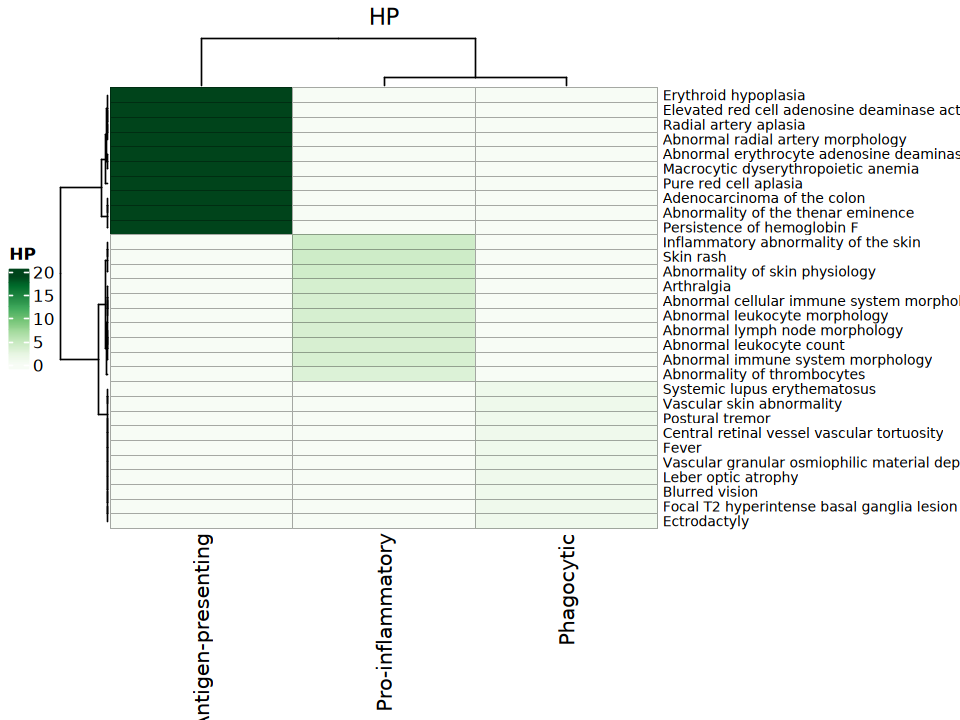

In [51]:
ht <- get_ht(s="HP", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")

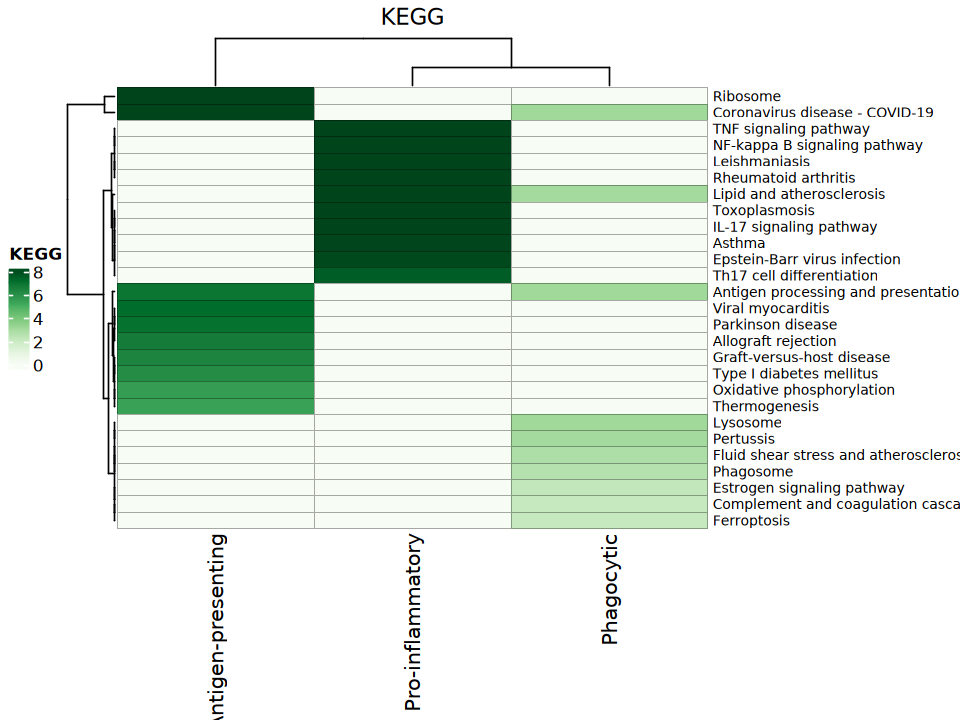

In [52]:
ht <- get_ht(s="KEGG", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")

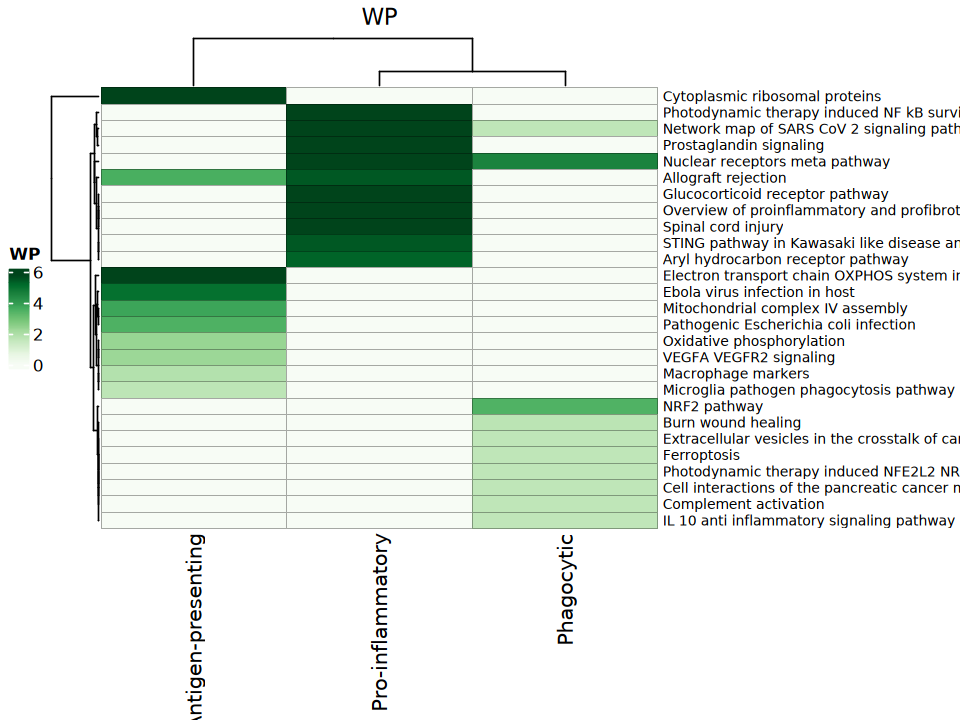

In [53]:
ht <- get_ht(s="WP", df_go=df_go)

draw(ht,  heatmap_legend_side = "left")